# ML regression model as a surroage model

In [3]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

## Load data

* q_data: $q \in [0.1,5]^4$

* y_data: $\alpha^{v},\beta^{v},\alpha^{max},\beta^{max},\alpha^{min},\beta^{min}$ 归一化处理

* train:test=9:1  

* 5折交叉验证用于训练，即在训练集基础上分出20%为验证集

In [4]:
df=pd.read_excel(pm.file_datasets,index_col=0)

In [5]:
df.columns

Index(['q1', 'q2', 'q3', 'q4', 'alpha_vol', 'beta_vol', 'alpha_max',
       'beta_max', 'alpha_min', 'beta_min'],
      dtype='object')

In [6]:
df.columns=['q1', 'q2', 'q3', 'q4', r'$\alpha^v$', r'$\beta^v$', r'$\alpha^1$',
       r'$\beta^1$', r'$\alpha^2$', r'$\beta^2$']

In [7]:
df.describe()

,q1,q2,q3,q4,$\alpha^v$,$\beta^v$,$\alpha^1$,$\beta^1$,$\alpha^2$,$\beta^2$
count,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,2.600700,2.600554,2.599693,2.599807,15.094456,1.092729,123.085574,1.331359,56.525405,1.226724
std,1.385338,1.385518,1.385785,1.385893,6.036963,0.150210,46.114824,0.171567,22.556580,0.183597
min,0.200084,0.200386,0.200090,0.200222,0.561585,0.976145,9.008910,1.003005,4.666916,1.000099
25%,1.401405,1.400876,1.399161,1.399617,10.678713,1.011990,93.677995,1.228542,41.438695,1.118608
50%,2.600653,2.600804,2.599831,2.599082,15.366682,1.031559,121.284121,1.274907,55.800434,1.155044
75%,3.800111,3.800463,3.799689,3.800125,19.484902,1.093286,150.709236,1.356900,70.234569,1.242047
max,4.999808,4.999766,4.999649,4.999584,29.369184,1.806483,452.741789,2.312083,193.279605,2.221449


In [8]:
df.head(5)

,q1,q2,q3,q4,$\alpha^v$,$\beta^v$,$\alpha^1$,$\beta^1$,$\alpha^2$,$\beta^2$
0,4.961442,2.385522,2.896893,0.806421,20.223655,1.103777,175.209895,1.278621,77.992722,1.198342
1,2.509299,3.074866,0.972012,4.125319,16.398545,0.999593,51.617745,1.003269,38.960331,1.001141
2,1.773326,0.717280,1.926991,1.375933,5.623686,1.187663,81.553839,1.502992,31.950368,1.412077
3,1.550003,0.337619,1.263067,3.412958,3.454852,1.438510,86.902361,1.806967,33.457987,1.777304
4,4.681192,1.154233,0.885567,4.695532,16.217840,1.255864,160.651447,1.373127,83.251062,1.351132


In [9]:
feature_columns=[ r'$\alpha^v$', r'$\beta^v$', r'$\alpha^1$',
       r'$\beta^1$', r'$\alpha^2$', r'$\beta^2$']
for col in feature_columns:
    df[col]=(df[col]-df[col].mean())/df[col].std()

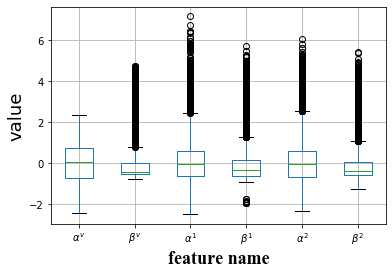

In [10]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [11]:
def box_plot_outliers(data_ser, box_scale):
    """
    利用箱线图去除异常值
    :param data_ser: 接收 pandas.Series 数据格式
    :param box_scale: 箱线图尺度，
    :return:
    """
    iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
    val_low = data_ser.quantile(0.25) - iqr
    val_up = data_ser.quantile(0.75) + iqr
    low_index = data_ser[data_ser < val_low].index
    up_index = data_ser[data_ser > val_up].index

    return list(low_index) + list(up_index)

In [12]:
error_index = []
for col in feature_columns:
    error_index += box_plot_outliers(df[col],box_scale=3)
df=df.drop(error_index)

In [26]:
#print(len(error_index))
#data_ser = df[feature_columns[0]]
#box_scale = 3
#iqr =(data_ser.quantile(0.75) - data_ser.quantile(0.25))
# print(iqr)

In [13]:
q_data,y_data=df.iloc[:,:4],df.iloc[:,4:]

In [14]:
train_size=int(0.9*len(q_data))

In [15]:
q_data_train,q_data_test=q_data.iloc[:train_size,:],q_data.iloc[train_size:,:]
y_data_train,y_data_test=y_data.iloc[:train_size,:],y_data.iloc[train_size:,:]

###  experimental data

In [16]:
q_data_exp,y_data_exp=df.iloc[-1,:4].values.reshape((1,-1)),df.iloc[-1,4:].values.reshape((1,-1))

In [17]:
q_data_train.shape,q_data_test.shape,q_data_exp.shape,y_data_exp.shape

((8171, 4), (908, 4), (1, 4), (1, 6))

In [18]:
q_data_exp

array([[1., 1., 1., 1.]])

## Regression model
* [k近邻](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=kneighborsregressor#)
* [xgboost](https://xgboost.readthedocs.io/en/latest/index.html)
* [muilt-layer perception](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlpregressor#)

##  Model trainning

* [Mulit-output regression model](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html?highlight=multioutputregressor#)  
This strategy consists of fitting one regressor per target. This is a simple strategy for extending regressors that do not natively support multi-target regression.
* [oof:](https://stackoverflow.com/questions/52396191/what-is-oof-approach-in-machine-learning)  
OOF simply stands for "Out-of-fold" and refers to a step in the learning process when using k-fold validation in which the predictions from each set of folds are grouped together into one group

In [19]:
# Class to extend the Sklearn regressor
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [20]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X = q_data_train.values
y = y_data_train.values
X_test = q_data_test.values
y_test=y_data_test.values

In [21]:
X.shape,y.shape,X_test.shape,y_test.shape

((8171, 4), (8171, 6), (908, 4), (908, 6))

- sub1:
'n_neighbors': 12,'p': 1
Test: mse loss=0.005278 r2_score=0.994480

- sub2:
'n_neighbors': 8,'p': 1
Test: mse loss=0.015084 r2_score=0.938500

- sub3 
'n_neighbors': 10,'p': 2
Test: mse loss=0.008681 r2_score=0.985060

- sub4:
'n_neighbors': 6,'p': 1
Test: mse loss=0.028811 r2_score=0.901175

- sub5:
'n_neighbors': 6,'p': 2
Test: mse loss=0.007086 r2_score=0.988484

- sub6:
'n_neighbors': 8,'p': 1
Test: mse loss=0.026195 r2_score=0.910336

In [22]:
'''
'n_neighbors': 1, 2, 4, 6, 8, 10
'p': 1, 2


'''
knn_para=[
    {'n_neighbors': 12, 'p': 1,
     'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'n_jobs': -1},
    {'n_neighbors': 8, 'p': 1,
     'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'n_jobs': -1},
    {'n_neighbors': 10, 'p': 2,
     'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'n_jobs': -1},
    {'n_neighbors': 6, 'p': 1,
     'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'n_jobs': -1},
    {'n_neighbors': 6, 'p': 2,
     'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'n_jobs': -1},
    {'n_neighbors': 8, 'p': 1,
     'algorithm': 'brute', 'weights': 'distance', 'metric': 'minkowski', 'n_jobs': -1},
]
feat_flag = 5
sub = KNeighborsRegressor(**knn_para[feat_flag])
sub.fit(X, y[:, feat_flag])
pred = sub.predict(X_test)
print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

Test: mse loss=0.026195 r2_score=0.910336


- sub1:
'n_estimators': 100,
    'max_depth': 8,
    'learning_rate':0.1, 
Test: mse loss=0.000411 r2_score=0.999570

- sub2:
'n_estimators': 100,
    'max_depth': 8,
    'learning_rate':0.1,
Test: mse loss=0.000615 r2_score=0.997493

- sub3 
'n_estimators': 100,
    'max_depth': 8,
    'learning_rate':0.1,
Test: mse loss=0.005294 r2_score=0.990889

- sub4:
'n_estimators': 75,
    'max_depth': 8,
    'learning_rate':0.1,
Test: mse loss=0.015822 r2_score=0.945729

- sub5:
'n_estimators': 100,
    'max_depth': 8,
    'learning_rate':0.1,
Test: mse loss=0.001872 r2_score=0.996958

- sub6:
'n_estimators': 75,
    'max_depth': 6,
    'learning_rate':0.1,
Test: mse loss=0.009799 r2_score=0.966458

In [23]:
'''
'n_estimators':100,50,75,150
'max_depth':4,6,8,16
'learning_rate':0.05,0.1,0.15
'''
xgb_para=[
    {'n_estimators': 100, 'max_depth': 8, 'learning_rate':0.1,
    'objective':'reg:squarederror', 'booster':'gbtree', 'n_jobs':-1},
    {'n_estimators': 100, 'max_depth': 8, 'learning_rate':0.1,
    'objective':'reg:squarederror', 'booster':'gbtree', 'n_jobs':-1},
    {'n_estimators': 100, 'max_depth': 8, 'learning_rate':0.1,
    'objective':'reg:squarederror', 'booster':'gbtree', 'n_jobs':-1},
    {'n_estimators': 75, 'max_depth': 8, 'learning_rate':0.1,
    'objective':'reg:squarederror', 'booster':'gbtree', 'n_jobs':-1},
    {'n_estimators': 100, 'max_depth': 8, 'learning_rate':0.1,
    'objective':'reg:squarederror', 'booster':'gbtree', 'n_jobs':-1},
    {'n_estimators': 75, 'max_depth': 6, 'learning_rate':0.1,
    'objective':'reg:squarederror', 'booster':'gbtree', 'n_jobs':-1},
]
feat_flag = 5
sub = XGBRegressor(**xgb_para[feat_flag])
sub.fit(X, y[:, feat_flag])
pred = sub.predict(X_test)
print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

Test: mse loss=0.009799 r2_score=0.966458


- sub1:
'hidden_layer_sizes': (75,),
    'learning_rate_init':5e-3,
Test: mse loss=0.000442 r2_score=0.999537

- sub2:
'hidden_layer_sizes': (75,),
    'learning_rate_init':5e-3,
Test: mse loss=0.001150 r2_score=0.995310

- sub3:
'hidden_layer_sizes': (100,),
    'learning_rate_init':5e-3,
Test: mse loss=0.005866 r2_score=0.989905

- sub4:
'hidden_layer_sizes': (75,),
    'learning_rate_init':5e-3,
Test: mse loss=0.018033 r2_score=0.936669
- sub5:
'hidden_layer_sizes': (100,),
    'learning_rate_init':5e-3,
Test: mse loss=0.001679 r2_score=0.997272

- sub6:
'hidden_layer_sizes': (75,),
    'learning_rate_init':5e-3,
Test: mse loss=0.010333 r2_score=0.965485

In [24]:
grid_params ={
    'hidden_layer_sizes' : [(256,), (512,), (1024,)],
    'learning_rate_init' : [5e-3, 1e-2, 5e-2, 0.05],
    'activation' : ['relu'],
    'early_stopping' : [True],
    'tol' : [1e-4],
    'n_iter_no_change' : [10],
    'max_iter' : [200]
}
clf = GridSearchCV(MLPRegressor(), grid_params, scoring = 'r2', n_jobs = -1, cv = 5)

In [25]:
feat_flag = 3
clf.fit(X, y[:, feat_flag])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=200,
                                    momentum=0.9, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_stat...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['relu'], 'early_stopping': [True],
                         'hidden_layer_sizes': [(256,), (512,), (1024,)],
            

In [26]:
clf.best_params_

{'activation': 'relu',
 'early_stopping': True,
 'hidden_layer_sizes': (1024,),
 'learning_rate_init': 0.005,
 'max_iter': 200,
 'n_iter_no_change': 10,
 'tol': 0.0001}

In [29]:
'''
'hidden_layer_sizes': (50,),(100,),(150,)
'learning_rate_init':5e-3,1e-2,1e-3,5e-2
'''
mlp_para = [
            {'hidden_layer_sizes' : (75,), 'learning_rate_init' : 5e-3, 'activation' : 'relu',
                            'early_stopping' : True, 'tol' : 1e-4, 'n_iter_no_change' : 10, 'max_iter' : 200},
            {'hidden_layer_sizes' : (75,), 'learning_rate_init' : 5e-3, 'activation' : 'relu',
                            'early_stopping' : True, 'tol' : 1e-4, 'n_iter_no_change' : 10, 'max_iter' : 200},
            {'hidden_layer_sizes' : (100,), 'learning_rate_init' : 5e-3, 'activation' : 'relu',
                            'early_stopping' : True, 'tol' : 1e-4, 'n_iter_no_change' : 10, 'max_iter' : 200},
            {'hidden_layer_sizes' : (200,), 'learning_rate_init' : 0.001, 'activation' : 'relu',
                            'early_stopping' : True, 'tol' : 1e-4, 'n_iter_no_change' : 10, 'max_iter' : 200,
                            'random_state' : 42},
            {'hidden_layer_sizes' : (100,), 'learning_rate_init' : 5e-3, 'activation' : 'relu',
                            'early_stopping' : True, 'tol' : 1e-4, 'n_iter_no_change' : 10, 'max_iter' : 200},
            {'hidden_layer_sizes' : (75,), 'learning_rate_init' : 5e-3, 'activation' : 'relu',
                            'early_stopping' : True, 'tol' : 1e-4, 'n_iter_no_change' : 10, 'max_iter' : 200},
        ]


feat_flag = 3
sub = MLPRegressor(**mlp_para[feat_flag])
sub.fit(X, y[:, feat_flag])
pred = sub.predict(X_test)
print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

Test: mse loss=0.017519 r2_score=0.939908


In [27]:
fold = KFold(n_splits=5, shuffle=True, random_state=42)


def run_6sub_oof(clf, params):
    models = []
    pred = np.zeros(y_test.shape)
    oof = np.zeros(y.shape)
    for index, (train_idx, val_idx) in enumerate(fold.split(X)):
        x_tr, y_tr = X[train_idx,:], y[train_idx, :]
        x_val, y_val = X[val_idx,:], y[val_idx, :]

        tr_pred = np.zeros(y_tr.shape)
        val_pred = np.zeros(y_val.shape)
        test_pred = np.zeros(y_test.shape)
        for ix, para in enumerate (params):
            sub_model = clf(**para)
            sub_model.fit(x_tr, y_tr[:, ix])
            tr_pred[:, ix] = sub_model.predict(x_tr)
            val_pred[:, ix] = sub_model.predict(x_val)
            test_pred[:, ix] = sub_model.predict(X_test)
            models.append(sub_model) 
        oof[val_idx, :] = val_pred
        print('_'*100)
        print(index+1, 'Train: mse loss = {:.6f} r2_score = {:.6f}, Validation: mse loss = {:.6f} r2_score = {:.6f}'.format(
            mse_loss(y_tr, tr_pred), metrics.r2_score(y_tr, tr_pred),
            mse_loss(y_val, val_pred), metrics.r2_score(y_val, val_pred)))
        pred = pred+ test_pred/fold.n_splits
        del x_tr, y_tr, x_val, y_val
    print("#"*100)
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y, oof),metrics.r2_score(y_test, pred)))
    return models,oof,pred

In [28]:
knn_models, knn_oof, knn_pred = run_6sub_oof(KNeighborsRegressor, knn_para)

____________________________________________________________________________________________________
1 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.010440 r2_score = 0.963964
____________________________________________________________________________________________________
2 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.012515 r2_score = 0.957531
____________________________________________________________________________________________________
3 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.013661 r2_score = 0.955230
____________________________________________________________________________________________________
4 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.009240 r2_score = 0.967023
____________________________________________________________________________________________________
5 Train: mse loss = 0.000000 r2_score = 1.000000, Validation: mse loss = 0.009306 r2_sc

In [33]:
xgb_models, xgb_oof, xgb_pred = run_6sub_oof(XGBRegressor, xgb_para)

____________________________________________________________________________________________________
1 Train: mse loss = 0.000128 r2_score = 0.999561, Validation: mse loss = 0.001287 r2_score = 0.996064
____________________________________________________________________________________________________
2 Train: mse loss = 0.000108 r2_score = 0.999632, Validation: mse loss = 0.002610 r2_score = 0.992005
____________________________________________________________________________________________________
3 Train: mse loss = 0.000122 r2_score = 0.999571, Validation: mse loss = 0.002467 r2_score = 0.992820
____________________________________________________________________________________________________
4 Train: mse loss = 0.000130 r2_score = 0.999557, Validation: mse loss = 0.001839 r2_score = 0.994588
____________________________________________________________________________________________________
5 Train: mse loss = 0.000146 r2_score = 0.999493, Validation: mse loss = 0.001216 r2_sc

In [34]:
mlp_models, mlp_oof, mlp_pred = run_6sub_oof(MLPRegressor, mlp_para)

____________________________________________________________________________________________________
1 Train: mse loss = 0.001755 r2_score = 0.994723, Validation: mse loss = 0.001209 r2_score = 0.996147
____________________________________________________________________________________________________
2 Train: mse loss = 0.001439 r2_score = 0.995817, Validation: mse loss = 0.002745 r2_score = 0.991625
____________________________________________________________________________________________________
3 Train: mse loss = 0.001420 r2_score = 0.995748, Validation: mse loss = 0.002415 r2_score = 0.993160
____________________________________________________________________________________________________
4 Train: mse loss = 0.001580 r2_score = 0.995214, Validation: mse loss = 0.001639 r2_score = 0.995347
____________________________________________________________________________________________________
5 Train: mse loss = 0.001762 r2_score = 0.994792, Validation: mse loss = 0.000542 r2_sc

### Model evaluation

* The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
* The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [35]:
print('Test: mse loss={:.6f} r2 score={}'.format(mse_loss(y_test,xgb_pred),metrics.r2_score(y_test,xgb_pred)))

Test: mse loss=0.005478 r2 score=0.9833220706390042


## Save model to local

In [37]:
from sklearn.externals import joblib
joblib.dump(knn_models, "./Results/knn_model.m")

['./Results/knn_model.m']

## Load model

In [38]:
from sklearn.externals import joblib
models = joblib.load("./Results/knn_model.m")

In [32]:
models = knn_models

In [33]:
def loss_func(x):
    # MSE 均方误差损失函数
    y_pre=np.zeros(y_data_exp.shape)
    for ix, model in enumerate(models):
        y_pre[:, ix % 6] += model.predict(x.reshape(1, -1))/5
    print(y_pre,y_data_exp)
    loss = mse_loss(y_pre, y_data_exp)
    return loss

# callback to save the function value.
def callback_save_func_val(xk, convergence):
    # xk is the current value of x0
    global niter
    niter=niter+1
    error=loss_func(xk)
    print('-'*100)
    print('niter={}:current x={},mse loss={}'.format(niter,xk,error))
    x_vec.append(xk)
    y_vec.append(error)
    return 

In [34]:
# experimental value test
loss=loss_func(q_data_exp)
print(loss)

[[-1.75607231 -0.39359753 -1.5791248   0.44261154 -1.63218512  0.37192332]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
0.037457370941375884


In [35]:
q_data_exp

array([[1., 1., 1., 1.]])

## optimation process

In [ ]:
from scipy.optimize import differential_evolution
import random
start_time=time.clock()
global niter#niter:Number of evaluations of the objective functions and of its Jacobian and Hessian.
niter=0
start_time=time.clock()

lb=0.2*q_data_exp[0]
ub=5*q_data_exp[0]
x0=(random.random()*(ub-lb)+lb)
print('initiate point x:',x0)
x_vec,y_vec=[],[]
res=differential_evolution(loss_func,bounds=[(lb[i],ub[i])for i in range(len(lb))]
            , strategy='best1bin', maxiter=500, popsize=50, tol=1e-6, mutation=(0.5, 1)
            , recombination=0.7,callback=callback_save_func_val)
end_time=time.clock()
print ('#'*100)
print(res)
print('optimation cost time=%f(s)' %(end_time-start_time))

initiate point x: [4.2796596 4.2796596 4.2796596 4.2796596]
[[-0.29134905 -0.57071192 -0.66695274 -0.49268409 -0.66556215 -0.53323896]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.35859031 -0.16099172 -1.0628239   0.13562415 -1.15605779  0.03733792]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.49643836 -0.65438943 -1.46656915 -0.08105895 -1.45136801 -0.27498661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.04306588 -0.49117514 -1.01203443 -0.22517498 -1.06411338 -0.36765597]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.85168823 -0.29902011  0.6678539  -0.57398789  0.55430997 -0.51091199]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-2.01224004 -0.40432241 -1.89891     1.03504963 -1.88911435  0.86082189]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.47038307 -0.69022691 -1

[[ 1.01907644 -0.47639001  0.3756989  -0.76996244  0.47125224 -0.69862124]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.4448407  -0.40591239  0.86368288 -0.80026892  0.87530875 -0.70911989]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.35767335 -0.47508321 -0.62242405 -0.26960541 -0.56445355 -0.32357081]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.78632993 -0.59146845 -0.93505233 -0.39737893 -0.90307816 -0.48096838]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.31475905 -0.47706294 -1.25464465 -0.07439267 -1.28730474 -0.22451303]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.14814033  1.2526991   0.66780909  0.52444939  0.94711837  0.92929483]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.03581195 -0.47424105 -0.16121936 -0.60950986 -0.18670726 -0.62224139]] [[-1.6877766

[[ 1.00647611 -0.55870369  0.12115097 -0.6680658   0.30621339 -0.69024563]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.33215663 -0.2116701  -1.06745323  0.36222751 -1.15340071  0.25973615]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.07704861 -0.20532058  0.92994281 -0.60866549  0.77713512 -0.51856212]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.58523632 -0.45218524  0.75382372 -0.81135315  0.85847712 -0.69730616]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.11503305 -0.62226139 -0.56602961 -0.55132505 -0.49478461 -0.61423079]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.32224021 -0.25555498  0.33029814 -0.49962047  0.19682719 -0.4697395 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.76819463  0.87685516 -0.06700246  0.5062735  -0.05007155  0.78575795]] [[-1.6877766

[[ 0.61596803 -0.53996956 -0.17129029 -0.48434979 -0.06872681 -0.56661938]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.33536193  1.03819897  0.44281152  0.49918991  0.53760906  0.73847391]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.52489919  0.23645653  0.92378391 -0.20656233  0.83552624  0.01321788]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72102562 -0.50788095 -1.6078375   0.17320398 -1.60300161  0.11000746]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.94459872 -0.26488007  0.76732759 -0.61757912  0.67693603 -0.54894713]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.12778259 -0.574812   -0.58359951 -0.30783373 -0.51728917 -0.47716258]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74406828 -0.43449969 -1.69943897  0.69626823 -1.76505462  0.50340257]] [[-1.6877766

[[-0.55871279 -0.62738315 -0.87187285 -0.39886633 -0.77753349 -0.50023665]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.88020713  0.21334454 -0.44452344  0.14793186 -0.61256918  0.15901571]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.85962658  1.18597756 -0.00621502  0.81210179  0.05530956  1.05728374]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.12008662 -0.51937172 -1.13294277 -0.10124047 -1.18017046 -0.23837951]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77332129 -0.61800612 -1.73712671  0.61039039 -1.72438054  0.26036217]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.48676535  0.27540338  0.84584342 -0.23974088  0.80303729 -0.03902449]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.26195271 -0.54281775  0.31330387 -0.80718521  0.50297032 -0.73625336]] [[-1.6877766

[[-0.2225072   0.97016632  0.45515567  0.3553568   0.60224404  0.66357252]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.49086975 -0.26306903 -1.18298649  0.21872008 -1.2549433   0.08470455]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.19368705 -0.19746289 -0.89614293  0.21761359 -1.03612728  0.11910221]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.8457426  -0.48966466  0.23395111 -0.75625244  0.26372705 -0.70562967]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.59879595 -0.27663198 -0.42189477 -0.20622918 -0.58441542 -0.25709193]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.19309365 -0.24797776  0.27222956 -0.40052258  0.11074745 -0.39670582]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.68145578 -0.44117906 -0.2065543  -0.15875939 -0.17435318 -0.34747935]] [[-1.6877766

[[-0.67497323 -0.6293527  -0.84685366 -0.51016444 -0.81944199 -0.59693849]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.13204646 -0.64757754 -1.29609772  0.10671398 -1.2600033  -0.25024192]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.97214376 -0.54942038 -1.84996151  0.70104413 -1.859667    0.55739585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.97760941 -0.33975675 -1.82590254  1.20686717 -1.83734679  0.95984939]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.33811132 -0.53696656  0.41792972 -0.8538747   0.61790225 -0.77038306]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.44773934 -0.50326861  0.52613142 -0.83924394  0.72817256 -0.73077347]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.27117178 -0.71491663 -1.37587949 -0.09733481 -1.34614035 -0.36468126]] [[-1.6877766

[[ 0.77089813 -0.54835808 -0.05038326 -0.57633204  0.07669175 -0.60826046]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.10424988  0.95246276 -0.28952689  0.70936255 -0.32897841  0.93217858]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.93420219 -0.68653714 -1.13112043 -0.25251409 -1.09891639 -0.46534766]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.63514138  0.97955741  0.12843554  0.57702651  0.1483267   0.89274534]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.00110212 -0.45189149 -0.2153849  -0.52597926 -0.26079682 -0.53469364]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.026873   -0.58253712 -0.44391314 -0.58715831 -0.35597147 -0.60344969]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.45409113 -0.54155691 -0.0653647  -0.72660358  0.05334911 -0.69597706]] [[-1.6877766

[[ 1.64687862 -0.47429623  0.75361588 -0.84386245  0.88857186 -0.72917682]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.60867733 -0.34324904 -0.51014302 -0.27312582 -0.62171562 -0.35069631]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.25745372 -0.5458324   0.34283607 -0.82588625  0.49323998 -0.75944129]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.18769328 -0.46131072 -0.66563678  0.0497477  -0.70957209 -0.14181644]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.25230037 -0.5624434  -1.28456218 -0.03123962 -1.26326483 -0.16667747]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.75177804  0.19088947 -0.27431595  0.1654624  -0.46821497  0.2213904 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.54319579 -0.13425837 -1.16393316  0.26341558 -1.24856156  0.14974182]] [[-1.6877766

[[-1.70375084  0.24658876 -1.28594127  0.74970695 -1.39893491  0.7514454 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.07002252 -0.68587226 -1.21790216 -0.09540319 -1.13259586 -0.36740741]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.86860735 -0.46792693 -0.84841467 -0.29634601 -0.88251105 -0.41893692]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.93772674  0.29514218 -0.42293474  0.32655693 -0.48754289  0.32494648]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.35770431 -0.52636241 -0.59868239 -0.46900966 -0.59910178 -0.50335616]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.18725154 1.03888209 0.85344021 0.28022488 1.39295003 0.67284331]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57413004 -0.57567581 -1.61172934  0.54425699 -1.62029618  0.24453304]] [[-1.68777667 -0.5

[[-1.1448452   0.78732189 -0.39891449  0.79085527 -0.49901639  0.88050233]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.70486762 -0.50840674 -0.13864538 -0.39996488 -0.046603   -0.49596477]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.34396872  1.00388818  0.39476047  0.35976811  0.58699076  0.70757009]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72483487 -0.63933486 -1.6868966   0.10482118 -1.60451538 -0.02647367]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.15542494  0.1332722   0.25070562 -0.14166603  0.0813201  -0.07571274]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.3422567   0.6826967  -0.66088224  0.71240896 -0.74960435  0.77980047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60382725 -0.37724222 -1.44109813  0.18324968 -1.46502529  0.06618778]] [[-1.6877766

[[ 0.48654906 -0.59468695 -0.21329866 -0.67510482 -0.0453986  -0.69444494]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.58014833 -0.7284953  -1.6000553   0.15891832 -1.58151513 -0.13622055]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66002709 -0.19448106 -1.36408049  0.27599639 -1.37917148  0.22854526]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.942054   -0.23442102 -1.81266521  0.92958505 -1.79076173  0.80878485]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.00577174 -0.55637707 -0.39013216 -0.60447617 -0.32980756 -0.61567113]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.42006388  0.34764201 -0.91448021  0.72489566 -1.03236566  0.67312358]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.61451115  0.02444652 -0.19287704 -0.08802649 -0.33536643 -0.09789763]] [[-1.6877766

[[-1.52490051 -0.72169633 -1.55538588 -0.04922049 -1.47707992 -0.25328379]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.61704908 -0.60616954 -0.95120158 -0.14937158 -0.90240359 -0.41323299]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.97558004 -0.0994187  -0.6537015  -0.0354926  -0.80749226 -0.08922023]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.07575796 -0.72485834 -1.2296475  -0.3148883  -1.17657685 -0.50088307]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.43089723 -0.01759478 -1.09988087  0.36908469 -1.18340041  0.22747276]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.04984765 1.20715911 0.73232605 0.42820671 1.0831116  0.82824286]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.38217938  0.24891992 -0.98136155  0.43079374 -1.13921454  0.45142077]] [[-1.68777667 -0.5

[[-1.81819389 -0.51109399 -1.71041142  0.53215463 -1.7531375   0.32241462]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.90728966 -0.6551464  -1.06949566 -0.38355181 -1.02335191 -0.49799505]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.22315625 -0.52114092 -1.14973156 -0.20856382 -1.15786175 -0.35796342]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73467148  0.36416965 -1.27148325  0.90676773 -1.37062211  0.86599083]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.15059573  1.18485552 -0.28932791  0.87427788 -0.30689153  1.14429067]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.41786921  0.1169254  -1.00642221  0.35663755 -1.16754783  0.33105963]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.12784312 -0.02550199 -0.72449646  0.10111702 -0.84701662  0.01691141]] [[-1.6877766

[[-1.53866527 -0.60170837 -1.45455984 -0.02641855 -1.43983659 -0.20171104]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.29445616 -0.07359443 -0.95991525  0.15579718 -1.11750173  0.06335784]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.33199782 -0.08371615 -1.02628972  0.24212811 -1.12305617  0.11113533]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.04324564 -0.68044687 -1.22592483 -0.0514359  -1.19552468 -0.37471172]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.43870987 -0.63439506 -1.42978127 -0.14508257 -1.4009034  -0.30535004]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.99160638 -0.4640165  -1.89047726  0.98915216 -1.86132803  0.80709298]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.86523431 -0.26311712 -1.71218485  0.75649759 -1.75688787  0.56265754]] [[-1.6877766

[[-1.17038498 -0.6979521  -1.28621408 -0.19759578 -1.24329524 -0.40056132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57010243 -0.71428657 -1.62887545  0.30050858 -1.61960194 -0.09244462]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.53847356 -0.6646264  -0.83767932 -0.52353854 -0.77983688 -0.62771365]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70489695  0.63061646 -1.13650598  1.20930622 -1.21639305  1.12435498]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.83616148 -0.48212058 -0.81978252 -0.33633658 -0.88579349 -0.44016505]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63918684 -0.7134566  -1.67981315  0.12729024 -1.65130367 -0.1064416 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.31467598 -0.7256901  -1.38092851 -0.1725685  -1.32887441 -0.39872408]] [[-1.6877766

[[-0.79439887 -0.52884308 -1.0542032   0.31503241 -1.13820178 -0.0675712 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.8444748   0.14043573 -1.47004301  1.04356083 -1.57190047  0.89059066]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.95831473 -0.47755313 -1.85625482  0.81212215 -1.81896728  0.57731702]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.98036371 -0.63070239 -1.18212192  0.09807335 -1.13135656 -0.27743797]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.37384441 -0.70014744 -1.46913801 -0.01854503 -1.37653429 -0.275406  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.46149943 -0.50918254 -1.34588669 -0.00532157 -1.3327064  -0.09159869]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.46622085 -0.43526038 -1.42078262  0.09941482 -1.44352816 -0.09812734]] [[-1.6877766

[[-1.76564223 -0.40372484 -1.64024649  0.37723756 -1.62352304  0.25329772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.90246017 -0.15542002 -1.67258762  0.77736817 -1.75549079  0.73814782]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82298709 -0.44221458 -1.77658643  0.70623245 -1.74429603  0.42292064]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.45809264  0.14762911 -1.06347643  0.53948677 -1.18629379  0.40217801]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-2.01271458 -0.39283851 -1.88800676  1.02031064 -1.88110593  0.7769151 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81535267 -0.68340127 -1.77576914  0.38753498 -1.73662956  0.11939174]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59505229  0.46979832 -1.11697528  0.93877064 -1.23717138  0.90547231]] [[-1.6877766

[[-1.69876424 -0.25883059 -1.55397572  0.47767742 -1.57347381  0.30927543]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.2685134  -0.63868652 -1.31301878 -0.16217242 -1.29693738 -0.32758875]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62357196 -0.68335353 -1.59810218  0.01182504 -1.52116169 -0.14833305]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.25682509 -0.39524272 -1.148226   -0.03487241 -1.18739475 -0.20270912]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82061691  0.35861083 -1.36924235  1.23060882 -1.45697497  1.08493675]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.51118903 -0.379798   -1.34761929  0.12993305 -1.35470961  0.01400679]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.91799837 -0.624362   -1.89029328  0.63293351 -1.84519773  0.41526853]] [[-1.6877766

[[-1.22225223 -0.50952354 -1.15047748 -0.18466897 -1.17143425 -0.30035268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-2.03656716 -0.45486008 -1.92124053  1.13108377 -1.89247079  0.81896103]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.49870103 -0.60671935 -0.82552135 -0.21787772 -0.79122435 -0.42852353]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.40657207 -0.6773841  -1.43234085 -0.20338863 -1.36727751 -0.35310975]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.24265095 -0.67564255 -1.40061915 -0.09529266 -1.36083459 -0.26768206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62062788 -0.47857021 -1.44770595  0.19498672 -1.52021171  0.01846463]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.24912574 -0.6931836  -1.44368383  0.08573875 -1.3811524  -0.28168205]] [[-1.6877766

[[-1.28534959 -0.33595635 -1.05997251 -0.03098909 -1.13030806 -0.17869938]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.53429488 -0.39075462 -1.33802576  0.19218494 -1.36418111  0.00466089]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.34316514 -0.67684479 -1.44578791  0.20149524 -1.40446325 -0.18849685]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59732607  0.0167398  -1.19966596  0.62972037 -1.30991069  0.44359824]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.50101604  0.09577111 -1.16722083  0.5023716  -1.2916947   0.42322425]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56357729 -0.69393613 -1.53107442 -0.07589494 -1.455652   -0.215767  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74759479 -0.63927107 -1.68957286  0.18334862 -1.67121607 -0.01417203]] [[-1.6877766

[[-1.38809157 -0.73098692 -1.45665557 -0.10667649 -1.37560703 -0.33214178]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76789431  0.14390136 -1.37318324  0.77242628 -1.425269    0.70888559]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.86351855 -0.41015772 -1.76294334  0.47046215 -1.74389276  0.36385788]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77765742 -0.6605422  -1.7691473   0.52556283 -1.73695705  0.18293673]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65990246 -0.48148056 -1.53481329  0.22707644 -1.52017936  0.03943258]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.2017748  -0.54931498 -0.43242769 -0.37531299 -0.37628092 -0.48067054]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66591714 -0.52789092 -1.58890366  0.2185049  -1.59113506  0.04454052]] [[-1.6877766

[[-1.31597234 -0.42024511 -1.26561831 -0.02514965 -1.28132107 -0.15504442]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70450732 -0.49557362 -1.60141083  0.17329224 -1.60503962  0.10493939]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66033298 -0.37082922 -1.49818609  0.22798394 -1.52261236  0.1171911 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77532948 -0.58983715 -1.69959638  0.33013607 -1.67233387  0.16881623]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82269923 -0.61947488 -1.78480709  0.49938777 -1.75280386  0.17594062]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.21450596 -0.71975471 -1.32891115 -0.24487234 -1.30423256 -0.42410277]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6228782  -0.60490539 -1.64378761  0.60981194 -1.62560277  0.20083522]] [[-1.6877766

[[-1.91050687 -0.65835517 -1.88084145  0.77193505 -1.84504399  0.42737142]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.34012333 -0.62762971 -1.35203993 -0.16454217 -1.35426348 -0.321147  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.86840486 -0.6419259  -1.82127866  0.46125961 -1.77231171  0.26602132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65250353 -0.29977524 -1.42826007  0.33575683 -1.52681071  0.20177885]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71195267  0.01326134 -1.51161658  0.62282672 -1.52069904  0.4918729 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59553421 -0.71169482 -1.61374677  0.16373543 -1.55722626 -0.11887853]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.11702443 1.19235259 0.80321153 0.38292438 1.2554377  0.83780036]] [[-1.68777667 -0.5

[[-1.34028699 -0.66054672 -1.41797991 -0.11575512 -1.37108592 -0.26886283]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.35177087 -0.70255237 -1.4421996   0.08718832 -1.43092317 -0.23163946]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.09464058 0.73792704 0.69823617 0.07300104 0.75043645 0.44955268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.34066951 -0.16245531 -1.1657036   0.35937437 -1.27514899  0.26890739]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.5985753  -0.69911668 -1.62130276  0.00686761 -1.57411533 -0.19724802]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.48402386 -0.13822839 -1.14252776  0.31825351 -1.28572079  0.26676983]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61618185 -0.72464065 -1.64728664  0.09563261 -1.62216905 -0.15744595]] [[-1.68777667 -0.5

[[-1.71936374 -0.31790202 -1.53293371  0.37875114 -1.51428363  0.26517042]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.43264399 -0.66441281 -1.4584957  -0.24318568 -1.38845754 -0.37384922]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72544321 -0.63560293 -1.74537763  0.43566171 -1.71817178  0.12950148]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.49956158 -0.49572541 -1.43046975  0.08549396 -1.37963758 -0.03091547]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71449783 -0.66847987 -1.73200098  0.62295489 -1.71985229  0.19827142]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.58496008 -0.64608745 -0.8496344  -0.45255309 -0.78503382 -0.54697835]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74395246 -0.57628404 -1.63324853  0.22023546 -1.63049448  0.13257793]] [[-1.6877766

[[-1.7099261  -0.53196932 -1.67174274  0.30240466 -1.68445244  0.08688232]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80964738 -0.63945296 -1.78505623  0.51911498 -1.77678079  0.20721275]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75768655 -0.57188834 -1.79148029  0.33181877 -1.73662072  0.19863519]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.98250728 -0.35473646 -1.84311959  0.94634445 -1.84010223  0.78158429]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64993252 -0.54065504 -1.6054527   0.18381464 -1.59158384  0.08103581]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=6:current x=[0.68186548 1.0437605  3.73354885 2.3513405 ],mse loss=0.0006819579155919897
[[-1.63285477 -0.65553333 -1.62902611  0.359

[[-1.7907763   0.16345242 -1.48562805  1.14586802 -1.52092856  0.93380752]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.2970747  -0.64442042 -1.32739224 -0.12959622 -1.37291832 -0.3052742 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62257346 -0.60254671 -1.61225555  0.24844444 -1.56143819  0.10796256]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61673644 -0.36284585 -1.4915512   0.31539588 -1.53754349  0.1698054 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70404937 -0.43331092 -1.5862818   0.26369294 -1.57339303  0.12644484]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77492166 -0.59717473 -1.76666042  0.75608331 -1.74734264  0.39159488]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.52791871 -0.71975522 -1.60242261  0.02125471 -1.53314622 -0.19895737]] [[-1.6877766

[[-1.46352754 -0.72841653 -1.48602452 -0.09069338 -1.45152393 -0.30061279]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63554164 -0.33540214 -1.44503738  0.4611579  -1.52141388  0.34669648]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78448439 -0.59536115 -1.68736887  0.29372152 -1.71218338  0.13074587]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.89501343 -0.48301284 -1.76909928  0.56504276 -1.78249055  0.45543723]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.4791784  -0.62921211 -1.45992277 -0.05703309 -1.4431831  -0.17588864]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.89805782 -0.43049224 -1.80003426  0.6023153  -1.7721459   0.56128713]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81761312 -0.54908743 -1.76686972  0.68798285 -1.78361778  0.42450028]] [[-1.6877766

[[-1.67061532 -0.67034971 -1.65797424  0.40427941 -1.65043257  0.09647164]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.55806503 -0.65774463 -1.50979489 -0.00182803 -1.50370223 -0.1721045 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.8333027  -0.60633583 -1.76433479  0.43497207 -1.71627875  0.23137039]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.58431096 -0.64277922 -1.52704729 -0.06286575 -1.46348029 -0.21950641]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73063687 -0.35889493 -1.5978019   0.37264125 -1.61260843  0.23316313]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6777699  -0.60549261 -1.62012778  0.13540727 -1.58797073 -0.05156172]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71850299 -0.6269198  -1.6538792   0.20592704 -1.646151    0.0352951 ]] [[-1.6877766

[[-1.78801958 -0.50073373 -1.75991816  0.66973826 -1.74428025  0.49197764]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74526918 -0.54039053 -1.66179075  0.46512213 -1.68561097  0.19821743]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63048513 -0.44823408 -1.54676296  0.65102976 -1.59456324  0.45859289]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73486259 -0.68805563 -1.75398181  0.2928639  -1.6585598   0.00393689]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81085977 -0.46391434 -1.60456704  0.39425826 -1.65899873  0.25288119]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67976367 -0.67211948 -1.65746978  0.11723585 -1.61034158 -0.07597814]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.38942585 -0.5518206  -1.36953     0.08217411 -1.37905691 -0.05498342]] [[-1.6877766

[[-1.75847806 -0.61145847 -1.71327853  0.29224582 -1.67341215  0.09991092]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.52657497 -0.43263901 -1.46857614  0.35464569 -1.44640841  0.21048261]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72352655 -0.70025724 -1.73415233  0.19609911 -1.67860887  0.00812693]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.46925788 -0.31270542 -1.26737027  0.34449997 -1.40233657  0.18717414]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82645092  0.00277733 -1.54807876  0.84520914 -1.6281765   0.79599805]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62684129 -0.49963044 -1.50389505  0.10076448 -1.48434907 -0.0301257 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62221925 -0.55284466 -1.58002231  0.13876553 -1.5762329  -0.03306176]] [[-1.6877766

[[-1.54615748 -0.58464619 -1.50684624  0.02333472 -1.50341026 -0.11950825]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63019045 -0.5008449  -1.52827639  0.18279098 -1.525648    0.03634741]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57682952 -0.12994424 -1.28695667  0.39842396 -1.37064172  0.26370531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.54440353 -0.69808839 -1.56121649 -0.01257601 -1.54347481 -0.22885673]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59295317 -0.41092758 -1.47657871  0.23263805 -1.47088171  0.06476769]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.54400998 -0.3844573  -1.42408206  0.22172469 -1.44969875  0.05715046]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72385298 -0.53102017 -1.64045107  0.2885215  -1.60707722  0.13809771]] [[-1.6877766

[[-1.6499961  -0.59861038 -1.61797327  0.21540982 -1.6231595   0.00745281]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78083731 -0.65320949 -1.7373896   0.35882103 -1.71347019  0.07917041]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.49450138 -0.56503624 -1.54240336  0.61311015 -1.56734925  0.25656165]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64165269 -0.13877981 -1.40195589  0.44364076 -1.4693736   0.36428011]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64396036 -0.35291538 -1.51089394  0.42723098 -1.52996712  0.27483291]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72613022 -0.58161025 -1.63306672  0.24199148 -1.65109939  0.07769041]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84884523 -0.62497853 -1.80500239  0.73622563 -1.77443493  0.36658791]] [[-1.6877766

[[-1.7186755  -0.23237536 -1.57633351  0.75468793 -1.60599811  0.53886493]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79899215 -0.66166151 -1.75945248  0.30053966 -1.70659161  0.09154958]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6889371  -0.67534006 -1.65602212  0.10091495 -1.5609508  -0.07107417]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78605731 -0.4391288  -1.68158827  0.58663617 -1.69350707  0.36970586]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81246383 -0.69575839 -1.79610306  0.46381909 -1.7510756   0.14962682]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6910099  -0.33435992 -1.48671201  0.64569414 -1.56097796  0.49128589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.52394896 -0.50910714 -1.44720827  0.23129478 -1.492773    0.06152019]] [[-1.6877766

[[-1.70525532 -0.40704197 -1.59936161  0.43467894 -1.60226366  0.24269561]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71091518 -0.57382842 -1.62935533  0.33329554 -1.63261729  0.17393816]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67599172 -0.55772851 -1.58974847  0.2128834  -1.59273827  0.05802652]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75309425 -0.50998395 -1.67754444  0.33019979 -1.63173272  0.12653431]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69391765 -0.53582447 -1.57919106  0.20105268 -1.57473125  0.01754685]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63310652 -0.43127559 -1.4754811   0.24886696 -1.46292815  0.09471086]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7398179  -0.41988051 -1.57537123  0.31269569 -1.5787392   0.18333257]] [[-1.6877766

[[-1.52631837 -0.47529719 -1.43790654  0.05315764 -1.42083611 -0.09377287]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74949646 -0.36148152 -1.6006223   0.45560276 -1.64546846  0.31157046]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.58268609 -0.69927129 -1.61678996  0.08634317 -1.56981609 -0.11156175]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61657579 -0.53714292 -1.60602926  0.48389808 -1.59379074  0.24231047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61657931 -0.33936412 -1.41465757  0.21392089 -1.43236645  0.1297773 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56380804 -0.44945986 -1.52237683  0.23190671 -1.50765687  0.07519008]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70786537 -0.59867928 -1.65511797  0.22785109 -1.64210945  0.04167457]] [[-1.6877766

[[-1.78891786 -0.63278664 -1.71551726  0.28345357 -1.70476092  0.11244949]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78679616 -0.63971386 -1.72033749  0.17798234 -1.66177754  0.00772142]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.51822184 -0.68471886 -1.5566915  -0.13686392 -1.49404658 -0.30349589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66023908 -0.41199954 -1.50742841  0.24290337 -1.49566539  0.06602803]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56440614 -0.68966285 -1.55609393 -0.04048476 -1.51865437 -0.2055124 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69447554 -0.41330628 -1.53729318  0.23936926 -1.5585017   0.09849797]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78882985 -0.50513195 -1.68666229  0.3045742  -1.68956462  0.2229658 ]] [[-1.6877766

[[-1.63518033 -0.58029783 -1.57386044  0.11398712 -1.51043684 -0.05306421]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72885401 -0.53308342 -1.66727026  0.35409518 -1.62222122  0.22253787]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69006168 -0.47315292 -1.5742441   0.30457881 -1.62924732  0.21569763]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80803517 -0.61748555 -1.72546996  0.27545439 -1.65736128  0.11143147]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73613002 -0.55697295 -1.66723756  0.23344697 -1.64288528  0.07291703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.53985208 -0.7171389  -1.59432018  0.0301344  -1.53468907 -0.20598996]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67121031 -0.21712025 -1.51712283  0.71546814 -1.57337888  0.59847846]] [[-1.6877766

[[-1.73072773 -0.40914339 -1.56402481  0.54790907 -1.5861329   0.34158267]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59527625 -0.53903871 -1.52522731  0.13881615 -1.50731998 -0.00897109]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64279217 -0.5662923  -1.55415737  0.15628215 -1.57222539 -0.04161531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70064213 -0.52934965 -1.63533996  0.32084854 -1.65963723  0.23082674]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6196878  -0.48303121 -1.52796253  0.23257229 -1.52420528  0.1074437 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.55846929 -0.52606075 -1.54458837  0.3049079  -1.56834657  0.15141199]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59583809 -0.48337412 -1.49506849  0.15115394 -1.47720194  0.04219867]] [[-1.6877766

[[-1.55623138 -0.60184171 -1.52693363  0.1139831  -1.49909407 -0.06473278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.49478865 -0.64406248 -1.44703368 -0.13068711 -1.3943905  -0.27171118]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63437882 -0.56383298 -1.572715    0.18688479 -1.56169744 -0.03652564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63571893 -0.4717335  -1.50543806  0.20923113 -1.53241213  0.1070546 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6540121  -0.60256012 -1.59206805  0.12632944 -1.61149127 -0.03930846]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69957184 -0.70711889 -1.71352963  0.27302117 -1.66648988 -0.01364635]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59933216 -0.53690941 -1.56439947  0.54127595 -1.58364375  0.31326514]] [[-1.6877766

[[-1.73894595 -0.61887349 -1.63770971  0.21640571 -1.64051914  0.02984737]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.93143659 -0.48177096 -1.85848206  0.81098779 -1.82419246  0.60151091]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66512362 -0.57087259 -1.60109523  0.19439101 -1.57464066  0.02348526]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=10:current x=[0.96208963 1.02145022 3.01683059 1.20329491],mse loss=0.00036043569659007234
[[-1.5903704  -0.67766157 -1.59297196  0.00937892 -1.55240075 -0.16593078]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68336011 -0.56053894 -1.61978407  0.10679417 -1.57201552  0.00489764]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.655598   -0.32957537 -1.54174927  0.8

[[-1.68327769 -0.643275   -1.68154673  0.24076121 -1.70065729  0.0176123 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.38984    -0.53422076 -1.37008943  0.09190963 -1.37420663 -0.06243215]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70186086 -0.10963524 -1.45481586  0.65639634 -1.51302933  0.40969777]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71317737 -0.57197292 -1.62830842  0.22439289 -1.62309753  0.03985549]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62020339 -0.6418089  -1.57773232  0.06895449 -1.57692128 -0.11299348]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.840192   -0.65547196 -1.78736316  0.3829622  -1.73416435  0.17304486]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66147309 -0.70238826 -1.68470669  0.29204997 -1.59281683 -0.05609411]] [[-1.6877766

[[-1.61249157 -0.51663842 -1.5264283   0.1586356  -1.51559288  0.03972036]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62011255 -0.71553015 -1.59549323  0.060208   -1.56121095 -0.18756453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67456304 -0.41416757 -1.55658153  0.35361803 -1.61531175  0.30752681]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77240717 -0.61294278 -1.81911449  0.78765236 -1.82242955  0.44323358]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74538837 -0.55507456 -1.65950833  0.27859495 -1.63731759  0.06250336]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61929538 -0.62753601 -1.59099919  0.14593795 -1.57248222 -0.03645962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62612694 -0.57419189 -1.49452881  0.11516281 -1.53496898 -0.04727701]] [[-1.6877766

[[-1.71909144 -0.55125553 -1.60687412  0.27266071 -1.61693185  0.07795506]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78848577 -0.5609347  -1.68001602  0.41266085 -1.68678848  0.20929819]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59802424 -0.44962339 -1.49206362  0.20073794 -1.50174291  0.04761446]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71513346 -0.65715287 -1.63125233  0.15364577 -1.5819222  -0.02131809]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73845418 -0.61191998 -1.68298674  0.22771464 -1.64418317  0.10890882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.89909111 -0.17216348 -1.65542332  0.81778841 -1.69189477  0.70062435]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6720249  -0.66480423 -1.63987246  0.06837178 -1.5875555  -0.12225654]] [[-1.6877766

[[-1.90831936 -0.58989532 -1.83479698  0.76581591 -1.77864828  0.42307998]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73469485 -0.49731086 -1.59808509  0.30064092 -1.56775075  0.1102105 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68642786 -0.22057398 -1.39961701  0.39586979 -1.45795888  0.33966428]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69040771 -0.58501326 -1.62520469  0.19209419 -1.55752754  0.0561786 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.704234   -0.66378743 -1.64538829  0.09844832 -1.59177169 -0.06962439]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67755308 -0.59891247 -1.6182393   0.19827577 -1.58275695  0.06060731]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7698052  -0.58047137 -1.6554517   0.19650531 -1.60615974  0.04448483]] [[-1.6877766

[[-1.66617146 -0.53061736 -1.56331548  0.22297474 -1.59846574  0.04887889]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68664387 -0.63619604 -1.64483879  0.13414362 -1.5907227  -0.07111949]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69746533 -0.61454547 -1.75610441  0.19333374 -1.74131925  0.09879211]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64795074 -0.58576851 -1.60468895  0.15630783 -1.58696107 -0.02587579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7081423  -0.54614029 -1.59832999  0.20118078 -1.56115429  0.03871126]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7617726  -0.63290595 -1.69248801  0.30729342 -1.68152251  0.12952246]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65497797 -0.67681806 -1.59392074  0.07555769 -1.60033671 -0.12149373]] [[-1.6877766

[[-1.70376447 -0.45904716 -1.54519751  0.24210325 -1.53659842  0.10801852]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85104754 -0.51587764 -1.78476362  0.64922345 -1.73551987  0.49978711]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74828972 -0.52847826 -1.66259331  0.36111046 -1.65585362  0.19377804]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75678482 -0.43964166 -1.66454299  0.44395565 -1.67066946  0.33350923]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73683578 -0.46599583 -1.63915758  0.4222507  -1.63173811  0.26552886]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72463576 -0.53040785 -1.63311865  0.26205363 -1.66054453  0.11309408]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7726923  -0.22609596 -1.5911205   0.74321872 -1.64133841  0.60502684]] [[-1.6877766

[[-1.72735015 -0.61905523 -1.6305588   0.16368206 -1.60613149  0.00179025]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68139723 -0.5081721  -1.58660667  0.31025583 -1.57622881  0.10980555]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71123871 -0.57679476 -1.60982998  0.13797897 -1.61159501 -0.00677733]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74109159 -0.59814155 -1.66325218  0.26635725 -1.68941865  0.09831032]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71791823 -0.72964447 -1.73812651  0.30296407 -1.71512571  0.01103191]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71256495 -0.54346677 -1.65559749  0.2287786  -1.61795686  0.05807569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70256175 -0.60140831 -1.65460935  0.21856    -1.63732906  0.06301263]] [[-1.6877766

[[-1.63304122 -0.62454448 -1.63649409  0.08128918 -1.61461187 -0.05638253]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69051586 -0.5316406  -1.59368114  0.23210661 -1.60651014  0.12236542]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62407965 -0.60996991 -1.63047797  0.42033534 -1.64510842  0.16503978]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75158762 -0.50209204 -1.59009179  0.2833465  -1.63562369  0.11531683]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.54458258 -0.52119664 -1.4342815   0.07469511 -1.42579069 -0.05811313]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75231737 -0.56515222 -1.71345013  0.38714363 -1.6902186   0.26539732]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66331811 -0.56727779 -1.59963505  0.15779012 -1.59424214  0.01028315]] [[-1.6877766

[[-1.69585201 -0.49427207 -1.62209981  0.32333541 -1.58314196  0.18182893]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67007995 -0.29685133 -1.4931091   0.34660777 -1.53828699  0.23881063]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78614106 -0.57644722 -1.69375441  0.31863579 -1.65367467  0.0960415 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71134405 -0.52621798 -1.61502718  0.28275746 -1.57120398  0.14276601]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67433458 -0.35623976 -1.53448039  0.46914382 -1.53858095  0.32682657]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77058331 -0.61771985 -1.70190491  0.30850216 -1.66031033  0.13743927]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74555824 -0.50617856 -1.63649617  0.32008366 -1.60353421  0.18162864]] [[-1.6877766

[[-1.64173896 -0.49074085 -1.53329419  0.20975552 -1.52872095  0.04881711]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64961331 -0.35073601 -1.48759253  0.21527132 -1.46785291  0.14503375]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64774413 -0.39580734 -1.47694509  0.18879062 -1.46509412  0.10933317]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65849923 -0.5242648  -1.55971768  0.18526176 -1.52979505  0.07526127]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60250315 -0.5918629  -1.56265787  0.07684934 -1.55327245 -0.083641  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6304057  -0.63328384 -1.58678271  0.20495497 -1.56023235 -0.00340363]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60449794 -0.67613619 -1.51833811  0.02626102 -1.54062074 -0.16734758]] [[-1.6877766

[[-1.77879332 -0.57081996 -1.70111144  0.27247742 -1.66523475  0.09197398]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72760901 -0.48463774 -1.59947936  0.26925469 -1.58816555  0.12025311]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70658748 -0.60823181 -1.63102835  0.11341226 -1.6196381  -0.05222724]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73297041 -0.35355002 -1.5631471   0.31123539 -1.55713406  0.22676396]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75150297 -0.61910315 -1.6801108   0.20295774 -1.60196976  0.00184204]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70247202 -0.19603105 -1.45100828  0.69329422 -1.54921243  0.56889078]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65413531 -0.49271969 -1.5563572   0.17591433 -1.52384359  0.11407085]] [[-1.6877766

[[-1.7769986  -0.61507563 -1.68610246  0.2621827  -1.66081586  0.06542571]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7386294  -0.57438429 -1.68954727  0.31298057 -1.65784636  0.12009773]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66487385 -0.59084794 -1.61665812  0.19997628 -1.62442082  0.01623094]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77717575 -0.56679801 -1.6865577   0.33898173 -1.68522951  0.14209873]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70211249 -0.40929072 -1.54362776  0.35454227 -1.570296    0.17373276]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64693359 -0.51784075 -1.58979602  0.29566895 -1.60213537  0.1118968 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68038213 -0.47381682 -1.59314243  0.26291147 -1.5973218   0.14190899]] [[-1.6877766

[[-1.71338988 -0.54912717 -1.63669558  0.21668313 -1.64265468  0.08312732]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62771887 -0.49144895 -1.48939665  0.1623228  -1.50948322 -0.00208717]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72971493 -0.53684896 -1.63399036  0.24168758 -1.62738228  0.06367734]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63585708 -0.62300608 -1.57902359  0.11381716 -1.5370645  -0.08745963]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7414341  -0.13030006 -1.52018951  0.70854867 -1.57221946  0.47333679]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63607451 -0.56186702 -1.58203416  0.20064053 -1.59730715  0.03189381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74777766 -0.5392707  -1.62804647  0.22007663 -1.58546076  0.059626  ]] [[-1.6877766

[[-1.70296265 -0.62883065 -1.64636987  0.19896379 -1.60511454  0.02153544]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63223012 -0.49806065 -1.50178898  0.09229881 -1.50300599  0.09078088]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78221443 -0.67619934 -1.74174187  0.2907075  -1.71149334  0.10063928]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71414225 -0.4532904  -1.59461869  0.32954407 -1.59529879  0.22453531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6790478  -0.49505473 -1.58356017  0.32058659 -1.59533781  0.15667699]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.55607368 -0.64690184 -1.46551745 -0.0718064  -1.47792664 -0.2075438 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77501068 -0.04194997 -1.48429361  1.00845602 -1.612265    0.80820107]] [[-1.6877766

[[-1.68892649 -0.55735572 -1.61882008  0.16444549 -1.59406145  0.01705693]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=14:current x=[0.85068834 0.98161908 3.84096778 1.88171222],mse loss=9.844427606193325e-05
[[-1.80408841 -0.51131936 -1.67981457  0.41593382 -1.67737712  0.20671151]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60169713 -0.67881804 -1.55326939 -0.07954726 -1.52456277 -0.20955396]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68838404 -0.7061642  -1.75087539 -0.100564   -1.68610706 -0.16635024]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74422884 -0.54226503 -1.66214532  0.37736061 -1.63519242  0.19762242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73855191 -0.37921008 -1.60047921  0.38

[[-1.72579921 -0.47422006 -1.61180062  0.39685141 -1.63681878  0.17996238]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62449589 -0.55107491 -1.54871581  0.11894341 -1.53076338 -0.02716102]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75001622 -0.65023311 -1.68590351  0.33330528 -1.67671493  0.07449708]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81463251 -0.39324849 -1.70700419  0.80053223 -1.75730001  0.6411209 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69079786 -0.54737633 -1.61061628  0.20887959 -1.57320699  0.03405595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7672209  -0.59411745 -1.69742414  0.33588989 -1.68406077  0.14959231]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72275736 -0.53156956 -1.63457812  0.34198979 -1.63808158  0.10566255]] [[-1.6877766

[[-1.78502515 -0.54824924 -1.68641221  0.37105979 -1.65521932  0.22272034]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80655467 -0.54867144 -1.71251907  0.49705341 -1.69947651  0.32126839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75016562 -0.46834668 -1.59802851  0.29533868 -1.58325963  0.16096127]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73117659 -0.46729741 -1.61443526  0.5131294  -1.62201683  0.27702812]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7776443  -0.48831714 -1.66128091  0.48819789 -1.70672988  0.27484815]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69279707 -0.5741704  -1.59776723  0.10796624 -1.57594119 -0.02267752]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78119038 -0.49162046 -1.73990314  0.52426806 -1.69570553  0.34169169]] [[-1.6877766

[[-1.65551241 -0.57348451 -1.56129515  0.18914472 -1.56269718  0.00657546]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75620901 -0.26203991 -1.51779808  0.52733508 -1.58853017  0.36347266]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67860131 -0.46394088 -1.58376751  0.26429258 -1.57969821  0.11741829]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77424102 -0.55088643 -1.69027846  0.4232391  -1.67440917  0.27509266]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74360454 -0.62907595 -1.65723756  0.16246789 -1.64375146  0.03898265]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78889444 -0.38202898 -1.66485027  0.62592339 -1.66450288  0.41525311]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63350513 -0.54330394 -1.55956059  0.08198262 -1.57838999 -0.01428655]] [[-1.6877766

[[-1.76950208 -0.55708786 -1.6311975   0.30810315 -1.62754798  0.11697141]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74318726 -0.64973196 -1.66013367  0.1806755  -1.64520511 -0.04536036]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70615005 -0.57552352 -1.61567347  0.19967825 -1.59159449  0.02401896]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73378305e+00 -6.04289608e-01 -1.66231992e+00  1.64069823e-01
  -1.59077923e+00 -1.23271294e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7158824  -0.50340758 -1.60106259  0.21572797 -1.57258454  0.08573032]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67737955 -0.59541943 -1.62437677  0.15133785 -1.58903743  0.02396549]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75377361 -0.49712045 -1.69752188  0.63463131 -1.73687991 

[[-1.71734705 -0.623742   -1.64128842  0.17335751 -1.61592515  0.0159128 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7309055  -0.52204464 -1.64090763  0.21198876 -1.61178326  0.09894043]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66418736 -0.46364472 -1.58788977  0.19937468 -1.54097296  0.09911004]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76791251 -0.6135063  -1.68516076  0.25322058 -1.64589122  0.09456879]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73252627 -0.53467895 -1.62101367  0.31440904 -1.66753388  0.17298757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73581064 -0.66511674 -1.71606379  0.24377367 -1.67185031  0.06643803]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66844661 -0.51997755 -1.610509    0.27377925 -1.62741681  0.08200773]] [[-1.6877766

[[-1.70034086 -0.47767044 -1.57169541  0.30713648 -1.56606548  0.14742203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69096589 -0.58986994 -1.63145861  0.36656281 -1.61294484  0.1235715 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71277335 -0.51654938 -1.61414822  0.24176245 -1.60567439  0.08685062]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82663988 -0.39333239 -1.71846964  0.63781966 -1.72883177  0.50662199]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67572328 -0.53070967 -1.59317008  0.141655   -1.55602378 -0.01291972]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79831897 -0.57547178 -1.74165584  0.36995252 -1.71418247  0.23787334]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73953122 -0.55796937 -1.64167979  0.30505348 -1.6381053   0.13214632]] [[-1.6877766

[[-1.79408727 -0.62538994 -1.71038822  0.24982326 -1.73485854  0.05534392]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71287789 -0.61799681 -1.64381261  0.15503663 -1.63137664 -0.02252229]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7108551  -0.40020873 -1.59102532  0.28742171 -1.56946905  0.26193638]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74734426 -0.55885363 -1.65407536  0.26200533 -1.65149157  0.17346345]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6441759  -0.54873316 -1.59871985  0.23303667 -1.58672828  0.01704184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69271968 -0.60165487 -1.63601669  0.13339237 -1.61692659  0.01895689]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71052848 -0.64188371 -1.64937273  0.11092454 -1.61697417 -0.04379928]] [[-1.6877766

[[-1.8267686  -0.46742538 -1.7279208   0.50486582 -1.71111217  0.32789423]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69045189 -0.60206745 -1.61361564  0.14900882 -1.61685032 -0.01124372]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73007074 -0.61045291 -1.73352167  0.43763921 -1.73872801  0.19854817]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73484    -0.53744467 -1.674917    0.45451496 -1.62859227  0.27687402]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66693817 -0.61813815 -1.61457126  0.13652229 -1.6183674  -0.05829708]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6778585  -0.54701277 -1.61567997  0.17734491 -1.61203334  0.01428741]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70990156 -0.6627151  -1.67885604  0.22780447 -1.65567655  0.05096433]] [[-1.6877766

[[-1.71247466 -0.53935683 -1.6123598   0.17650156 -1.59824946  0.02092774]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65182881 -0.41238946 -1.58355359  0.61195152 -1.60533394  0.47314091]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64028    -0.64710593 -1.66776788  0.04902798 -1.58355244 -0.12269553]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72329807 -0.58017984 -1.63118341  0.12790102 -1.58587512  0.01059579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77003583 -0.50962029 -1.65474669  0.36691191 -1.65577849  0.15880862]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.86660008 -0.50993606 -1.77753935  0.63709668 -1.76543601  0.43791683]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62708551 -0.54333385 -1.57786307  0.14690458 -1.55160578 -0.02773486]] [[-1.6877766

[[-1.814718   -0.37999436 -1.68640487  0.62985128 -1.65295225  0.46152901]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72203273 -0.46423077 -1.58783414  0.2941633  -1.59223619  0.14294635]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67631622 -0.56896662 -1.66393167  0.31262687 -1.62885029  0.07261855]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69059707 -0.62134578 -1.68330278  0.22569046 -1.63305815  0.03261561]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71662026 -0.63614332 -1.6451623   0.12938523 -1.61548266 -0.01859256]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75788743 -0.61281984 -1.69390795  0.20045579 -1.66443456  0.07049638]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67791302 -0.62815724 -1.65194326  0.14278633 -1.60034395 -0.01524104]] [[-1.6877766

[[-1.77186038 -0.64213672 -1.73487451  0.27542554 -1.68827762  0.09314756]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76264308 -0.6101425  -1.64416269  0.10878815 -1.60695106  0.01086865]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68180059 -0.38421867 -1.61274381  0.60926333 -1.61936473  0.4460524 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77112271 -0.65305433 -1.70408996  0.24898556 -1.68437755  0.06769933]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69294178 -0.41116419 -1.5280606   0.21464518 -1.55789113  0.11503942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7414686  -0.33265262 -1.50398312  0.4483406  -1.54342931  0.27430577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71464715 -0.61379634 -1.65454488  0.22490758 -1.67025834  0.0710677 ]] [[-1.6877766

[[-1.76009733 -0.5704713  -1.67409102  0.32588773 -1.65715765  0.13089275]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66045103 -0.60005486 -1.62710024  0.06456895 -1.57230007 -0.08580517]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70677324 -0.52484459 -1.63403923  0.23837636 -1.62717516  0.14792247]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62132011 -0.6454571  -1.58907584  0.11633304 -1.57881474 -0.08607339]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65960508 -0.50454223 -1.56734539  0.24148604 -1.59011866  0.07625319]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80756963 -0.58422322 -1.68350714  0.22377681 -1.63893649  0.05542038]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6879023  -0.56751175 -1.6166492   0.21973519 -1.60006895  0.03641666]] [[-1.6877766

[[-1.75309844 -0.6019141  -1.67762237  0.27579115 -1.66841929  0.08804832]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71209908 -0.51276924 -1.63031694  0.28675218 -1.63953529  0.13860666]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63577539 -0.57851338 -1.58959856  0.14541414 -1.59030262 -0.01680574]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67973866 -0.5463247  -1.59279774  0.19976641 -1.61056067  0.03981356]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72990586 -0.57351128 -1.64768318  0.30707705 -1.65644461  0.11202292]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61192811 -0.55960733 -1.60643748  0.1843011  -1.57638066 -0.00488835]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73366975 -0.57913305 -1.65852671  0.18015854 -1.60479978  0.03335603]] [[-1.6877766

[[-1.73106604 -0.58263103 -1.64140191  0.20471074 -1.63530402  0.01653444]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70798077 -0.51941743 -1.63166947  0.27305245 -1.62701474  0.12925923]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80042798 -0.57208678 -1.69710236  0.33276934 -1.64422451  0.13263943]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67472898 -0.5400442  -1.64450117  0.1599939  -1.59330256  0.0022184 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68823328 -0.60927468 -1.64814674  0.17156663 -1.61303027  0.0143282 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66986351 -0.53454126 -1.5765689   0.21797793 -1.58919484  0.05126636]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6722963  -0.55697933 -1.60567261  0.311953   -1.58290313  0.11475025]] [[-1.6877766

[[-1.73955067 -0.61398292 -1.70137142  0.27441196 -1.66159853  0.0664379 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.89562853 -0.54830062 -1.78783302  0.55445435 -1.74760833  0.43289929]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78582412 -0.58417971 -1.69758853  0.32589177 -1.68621452  0.13069073]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73361424 -0.55806123 -1.65660514  0.20694856 -1.61604704  0.03489875]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70713223 -0.65422636 -1.64641998  0.18682341 -1.62148941 -0.03326904]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65960532 -0.54349507 -1.59383332  0.20016044 -1.58804263  0.01176049]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69378659 -0.58492017 -1.62885309  0.18011592 -1.60653797  0.01010621]] [[-1.6877766

[[-1.74936246 -0.55281456 -1.64843061  0.31725918 -1.64465084  0.20864667]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7199671  -0.4588859  -1.66886481  0.50402251 -1.65518994  0.34859568]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69951228 -0.54832346 -1.62179011  0.22151097 -1.59004772  0.0628908 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71047142 -0.69169256 -1.69548282  0.27946222 -1.67753868  0.00209216]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68746892 -0.57210647 -1.63202383  0.20030681 -1.62073614  0.03011657]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68390836 -0.54698835 -1.60262471  0.13775208 -1.59657558  0.05060284]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70535452 -0.55074931 -1.65041863  0.24019655 -1.58952301  0.04208345]] [[-1.6877766

[[-1.7161366  -0.61929338 -1.69847794  0.11343906 -1.62163451 -0.02718644]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80035369 -0.6544867  -1.79078958  0.33583867 -1.72852167  0.15997488]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73985924 -0.53696081 -1.69526685  0.2682694  -1.64543456  0.08002757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64654954 -0.60156612 -1.60360932  0.23169804 -1.55695413 -0.02002232]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67287598 -0.52550839 -1.57255819  0.23900458 -1.56495796  0.06991429]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73301045 -0.47810109 -1.63245121  0.31621273 -1.61930937  0.20681217]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7805459  -0.40360376 -1.62535235  0.54520159 -1.64913861  0.33096202]] [[-1.6877766

[[-1.72891794 -0.65387988 -1.69839485  0.24426486 -1.67468615  0.04773876]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72175571 -0.48268777 -1.65235068  0.29341073 -1.62217742  0.18689997]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74478963 -0.65383393 -1.68442727  0.16842216 -1.62870234 -0.00732284]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70947979 -0.53120847 -1.61153195  0.26041398 -1.60058218  0.06281532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62917594 -0.68469605 -1.68508272  0.0975474  -1.59885012 -0.07905587]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75744685 -0.7089793  -1.73606423  0.26844436 -1.70012792  0.03127295]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76664969 -0.57561041 -1.69920616  0.32707019 -1.67698933  0.17692243]] [[-1.6877766

[[-1.68187799 -0.59027082 -1.66097652  0.22288586 -1.64730901  0.08118239]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7328137  -0.49259156 -1.63672366  0.37749754 -1.63122549  0.24359142]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70388229 -0.46131965 -1.53174888  0.28015559 -1.5864255   0.09360472]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74344359 -0.61128271 -1.69828436  0.24349016 -1.69554457  0.05943662]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68050303 -0.48834573 -1.57881956  0.20124271 -1.58799687  0.06867868]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64901415 -0.60439123 -1.61730068  0.21837205 -1.5868696  -0.00545926]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63817237 -0.64948976 -1.62456157  0.18424338 -1.6065705  -0.04457314]] [[-1.6877766

[[-1.79164156 -0.60468272 -1.7108857   0.3386245  -1.66803682  0.16278699]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75162696 -0.62820323 -1.69971074  0.3345597  -1.71249974  0.12528268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68773876 -0.52588637 -1.57961226  0.2418392  -1.59612063  0.06127125]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73633397 -0.5452179  -1.61828941  0.18466147 -1.57968458  0.03990144]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70846788 -0.52743971 -1.57342028  0.2033321  -1.59828811  0.01700353]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76098215 -0.4349156  -1.60196621  0.23147417 -1.58959209  0.16531918]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64779308 -0.45307088 -1.50488926  0.27619948 -1.53880516  0.10138771]] [[-1.6877766

[[-1.75406709 -0.54585548 -1.74745739  0.5642345  -1.72882638  0.37841713]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.739614   -0.60282494 -1.69313312  0.26167454 -1.68089519  0.07478742]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74146069 -0.56933483 -1.66717881  0.38721362 -1.66070713  0.16515589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7456966  -0.60212005 -1.66670306  0.29557437 -1.68607948  0.1139606 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6706813  -0.56731589 -1.57685042  0.23060831 -1.61116875  0.03002907]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72801179 -0.54144686 -1.66322696  0.41585101 -1.63139197  0.18629753]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74276724 -0.57179941 -1.64688562  0.29026464 -1.65158173  0.11641014]] [[-1.6877766

[[-1.6855812  -0.51367832 -1.56245896  0.20403551 -1.59367205  0.0237026 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66017474 -0.56555448 -1.61509143  0.18574283 -1.58674027 -0.0232224 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65429429 -0.61064027 -1.59335618  0.22941359 -1.56762392 -0.03530787]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75958983 -0.61317941 -1.67571084  0.26944558 -1.64676801  0.0993878 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65789719 -0.58377049 -1.60711949  0.15832172 -1.57627498  0.00311654]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74341498 -0.47351527 -1.6517414   0.41440948 -1.63202054  0.28013718]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66928472 -0.59253155 -1.60511971  0.14414491 -1.59094243 -0.0042328 ]] [[-1.6877766

[[-1.76197831 -0.56255495 -1.69176154  0.23924149 -1.66110097  0.0824048 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67306173 -0.63732744 -1.66995042  0.26160266 -1.64886842  0.02612398]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73486541 -0.53851165 -1.66913317  0.54536076 -1.65202353  0.22992404]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72915935 -0.67096942 -1.67576266  0.15976223 -1.62760048 -0.03947585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78668552 -0.31804513 -1.60751054  0.72977661 -1.62935745  0.4710873 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75738357 -0.64023815 -1.70451266  0.26084161 -1.68382701  0.05089406]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67036464 -0.47102809 -1.58479059  0.40942    -1.61234384  0.16276176]] [[-1.6877766

[[-1.74078317 -0.66935254 -1.70844545  0.27201556 -1.68734573  0.03727175]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6727231  -0.55593646 -1.62768441  0.20584002 -1.61424872  0.03124778]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73132911 -0.59664905 -1.68273491  0.27334718 -1.67352131  0.13114604]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66632813 -0.55027428 -1.5730209   0.19481266 -1.57916796  0.06140335]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76836242 -0.63466024 -1.69354071  0.27649594 -1.68553749  0.07164543]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74128904 -0.52778598 -1.6177973   0.18269939 -1.61322814  0.05798709]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73490585 -0.53306431 -1.67111649  0.16931727 -1.62484524  0.11249782]] [[-1.6877766

[[-1.74638577 -0.5738744  -1.66635993  0.2440214  -1.65385089  0.07847901]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.8000584  -0.63964678 -1.73919643  0.3059287  -1.70402565  0.09414296]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76825136 -0.63589789 -1.72998428  0.31850954 -1.67008547  0.13206992]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73669972 -0.65166918 -1.70805578  0.19239504 -1.66675307  0.05060788]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65779698 -0.55689854 -1.62389084  0.09184877 -1.60642858  0.0064945 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73183322 -0.57553657 -1.61858772  0.20602379 -1.6224156   0.03479595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71320329 -0.50291871 -1.60599532  0.23616268 -1.61931294  0.08894223]] [[-1.6877766

[[-1.8463183  -0.43256748 -1.75507202  0.61291188 -1.71656272  0.4668296 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6965519  -0.52199829 -1.60710654  0.22051111 -1.57491384  0.05891058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69645111 -0.65763263 -1.67488223  0.27193201 -1.66606497  0.02343478]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64133331 -0.64387678 -1.63101864  0.16460302 -1.61393475 -0.01457358]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75097344 -0.4972612  -1.61649436  0.3407454  -1.63123337  0.1992146 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69276603 -0.59447208 -1.65239921  0.23282734 -1.6173671   0.07232662]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68422593 -0.56828128 -1.62438747  0.16436757 -1.58038133  0.01955369]] [[-1.6877766

[[-1.72530274 -0.59292392 -1.65530454  0.20553544 -1.59685509  0.04236968]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6310912  -0.57270526 -1.57544336  0.07280921 -1.57398704 -0.06159974]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68132623 -0.59331552 -1.62611023  0.18261063 -1.63669352  0.01946701]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82459409 -0.3970377  -1.70496468  0.60068065 -1.71744291  0.54139891]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63575339 -0.65124773 -1.61950459  0.11990428 -1.58360021 -0.07617106]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73040243 -0.58058705 -1.61780596  0.193584   -1.58688248  0.04375158]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66277422 -0.64039388 -1.64617826  0.22554888 -1.63624148  0.02178959]] [[-1.6877766

[[-1.76711125 -0.55656554 -1.69324151  0.39847191 -1.69707292  0.24767428]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68674356 -0.60490117 -1.63659046  0.16292155 -1.62346693 -0.01901132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67129632 -0.63924636 -1.65131447  0.14122345 -1.58908135 -0.01319282]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.8153466  -0.47657593 -1.71244553  0.57797974 -1.68488512  0.37665542]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66293287 -0.51078072 -1.60744006  0.3582431  -1.62642372  0.1260056 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69155296 -0.61846349 -1.69462471  0.22624879 -1.63387522  0.03501115]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73250841 -0.62716177 -1.70352215  0.22469427 -1.66055902  0.05259281]] [[-1.6877766

[[-1.76416622 -0.50281325 -1.66479058  0.36697959 -1.67647191  0.22136688]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68033629 -0.56395368 -1.56783645  0.1664473  -1.59881466 -0.00924828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68228127 -0.56678874 -1.57793084  0.11627274 -1.570526   -0.04950273]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.86233949 -0.56836664 -1.76585102  0.51053938 -1.72610858  0.39975693]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71977742 -0.54230934 -1.63835066  0.30800517 -1.63536101  0.12103906]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78560523 -0.55097893 -1.73242249  0.40720501 -1.6966275   0.22561682]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65240739 -0.54160255 -1.55626503  0.15499532 -1.56291508 -0.00646982]] [[-1.6877766

[[-1.76490418 -0.59557526 -1.65834182  0.19028793 -1.63761685  0.08749188]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81352374 -0.5749283  -1.74506795  0.49409029 -1.69915458  0.25811368]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72312266 -0.5513103  -1.69580576  0.51714129 -1.68806443  0.29730566]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69836362 -0.56273697 -1.67075739  0.24628756 -1.61841947  0.11113567]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72113711 -0.62549854 -1.7096792   0.16106002 -1.63136972  0.02011984]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72761113 -0.59837783 -1.67658366  0.28811059 -1.66427054  0.09021946]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6980294  -0.50611687 -1.60299451  0.2701259  -1.59200627  0.0875174 ]] [[-1.6877766

[[-1.74965138 -0.5375463  -1.65903435  0.27817041 -1.66320194  0.12701369]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71168987 -0.55998239 -1.61331387  0.20166938 -1.61306446  0.04907612]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73307293 -0.42354629 -1.59724756  0.49155184 -1.61919823  0.27653427]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68539326e+00 -5.90606201e-01 -1.60444464e+00  1.11303380e-01
  -1.59761985e+00 -8.72126972e-06]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69522622 -0.51965264 -1.62901465  0.3491942  -1.63569955  0.14412271]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73215101 -0.51142928 -1.61422676  0.21791837 -1.59476025  0.16333535]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67984335 -0.61665282 -1.64375468  0.18260017 -1.62576213 

[[-1.67584897 -0.59213168 -1.66956961  0.23377217 -1.66900836  0.08177584]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68428337 -0.4009479  -1.53930872  0.31774536 -1.52972695  0.15859361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62483601 -0.68511829 -1.59713747  0.00770776 -1.56473083 -0.17496826]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66471589 -0.6664374  -1.72608546  0.17999391 -1.64690836 -0.03978426]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72616769 -0.60502649 -1.64929723  0.19192769 -1.60293974  0.0135296 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71571561 -0.63121669 -1.66529244  0.25987543 -1.66587948  0.03333879]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68924875 -0.63647223 -1.63970242  0.14722305 -1.6078365  -0.03880662]] [[-1.6877766

[[-1.71782124 -0.62085419 -1.72011792  0.17358095 -1.68386164  0.02569887]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73822823 -0.56292784 -1.65276746  0.2528717  -1.65827185  0.11072196]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69028968 -0.5606918  -1.58162556  0.10617284 -1.54661473 -0.04350398]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64879933 -0.42250195 -1.55140202  0.23120158 -1.55212952  0.10641901]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71800368 -0.55909359 -1.58711861  0.24309247 -1.60573672  0.05084514]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61812771 -0.53148149 -1.61054127  0.35877462 -1.63059877  0.24377532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73463931 -0.64500754 -1.67239559  0.14888379 -1.61092278  0.01864811]] [[-1.6877766

[[-1.73118955 -0.34616926 -1.64881821  0.50136061 -1.67049383  0.45025694]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65229824 -0.68095316 -1.6309006   0.15104662 -1.61279861 -0.05313595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66717544 -0.58217177 -1.61714425  0.19168526 -1.60430736  0.00948348]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62920976 -0.62791157 -1.6184568   0.13339547 -1.57749538 -0.07499213]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74785215 -0.46544116 -1.63118364  0.33553537 -1.63042162  0.24075226]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64535675 -0.63503319 -1.62381387  0.1482301  -1.63178766 -0.04661327]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72840781 -0.47782512 -1.61219254  0.30491058 -1.62245053  0.13407098]] [[-1.6877766

[[-1.75895367 -0.6642541  -1.68714682  0.25468347 -1.6969702   0.07552304]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64583705 -0.64573751 -1.58281878  0.08700115 -1.56918953 -0.09291678]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76532937 -0.63766173 -1.72965681  0.27573985 -1.71161551  0.10832874]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78635416 -0.4941263  -1.66350545  0.51074385 -1.66193845  0.32762509]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72940594 -0.52304763 -1.6373306   0.30033126 -1.63577135  0.12018698]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74344089 -0.60386044 -1.68207274  0.2546409  -1.67020022  0.07063639]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6802864  -0.5412076  -1.59897346  0.30574996 -1.59997388  0.07376998]] [[-1.6877766

[[-1.63677144 -0.48578508 -1.55151721  0.14160535 -1.52748861  0.01296467]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73727091 -0.57883115 -1.72990912  0.32353847 -1.71127993  0.11671214]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73671339 -0.52577193 -1.63764456  0.18105486 -1.61339121  0.06866455]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67824397 -0.48206678 -1.59452195  0.38712649 -1.58528646  0.15333835]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85862368 -0.49417234 -1.77590786  0.65214831 -1.7283217   0.54640659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71837424 -0.60559393 -1.63838279  0.15214543 -1.59983779  0.02670361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79349087 -0.51675218 -1.6455334   0.23882299 -1.642642    0.15944355]] [[-1.6877766

[[-1.6723275  -0.44125532 -1.57960602  0.38990654 -1.58136677  0.23591749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7315563  -0.59628199 -1.68382315  0.20260795 -1.66394874  0.06162372]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70731727 -0.55726587 -1.60791379  0.15079076 -1.60976832  0.03449148]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72081697 -0.64251086 -1.69954015  0.19508245 -1.66236658  0.00200027]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78879446 -0.54930192 -1.71939478  0.494578   -1.72714307  0.34547797]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60973207 -0.65606158 -1.61041192  0.00490299 -1.529203   -0.11285735]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74266626 -0.62529165 -1.69672407  0.24791039 -1.68263941  0.07723977]] [[-1.6877766

[[-1.72090105 -0.53389072 -1.63351148  0.23826702 -1.63188756  0.14902525]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71706021 -0.62066776 -1.60545873  0.2336069  -1.618032   -0.00754017]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72792952 -0.5141504  -1.64224188  0.25013563 -1.64935927  0.14419818]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68397153 -0.56250745 -1.63836971  0.15659249 -1.60275699  0.02797112]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6124243  -0.57554909 -1.54728249  0.13109799 -1.56298978 -0.01292656]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6126231  -0.61706711 -1.57292446  0.13557781 -1.59642919 -0.05893052]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66246779 -0.52319509 -1.61843922  0.37059132 -1.627826    0.12461271]] [[-1.6877766

[[-1.72241564 -0.63836537 -1.64693     0.29163988 -1.66475471  0.04381248]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81510914 -0.45623583 -1.73457783  0.55895598 -1.68599487  0.42206418]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78627139 -0.69206752 -1.76854249  0.40969727 -1.66534399  0.15324892]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75869187 -0.47330078 -1.68595236  0.4871605  -1.67157388  0.34355348]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69097159 -0.58737493 -1.6321361   0.17182553 -1.6277277   0.03125557]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74975554 -0.58831847 -1.663927    0.26323089 -1.64605646  0.13869206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78258407 -0.50476227 -1.69442017  0.40770812 -1.65937278  0.21588938]] [[-1.6877766

[[-1.70495293 -0.48638836 -1.57210656  0.20827225 -1.59631952  0.06603788]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68139334 -0.60550041 -1.62773246  0.12533888 -1.59945408 -0.03295162]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77082093 -0.5800321  -1.69296381  0.40494921 -1.68870409  0.18622801]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67825704 -0.60393677 -1.68095507  0.21554033 -1.63887232  0.01177372]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70577741 -0.46220939 -1.64117264  0.3199827  -1.64813324  0.26096955]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61387271 -0.52280356 -1.57515727  0.13124954 -1.52330893  0.05222422]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74085374 -0.51618507 -1.67050475  0.41224372 -1.69378271  0.19144142]] [[-1.6877766

[[-1.78049382 -0.65361877 -1.7496599   0.32757726 -1.69097836  0.02218184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.87574055 -0.50496691 -1.77893313  0.81503868 -1.74552028  0.56819343]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66111233 -0.51296932 -1.5758574   0.22127683 -1.54758436  0.08184465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77248461 -0.61104499 -1.68782847  0.3927813  -1.70306171  0.13333177]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68189854 -0.48024427 -1.59397251  0.41000886 -1.57488162  0.14761732]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73620647 -0.46140565 -1.63273959  0.36616128 -1.67428296  0.17391049]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67947114 -0.57199054 -1.65066283  0.16221874 -1.61249327  0.03067949]] [[-1.6877766

[[-1.7363654  -0.55609595 -1.65044738  0.2485123  -1.65296596  0.09759157]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69791508 -0.55277899 -1.6349109   0.20963278 -1.6475916   0.07384096]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64296898 -0.64911898 -1.61796884  0.05412433 -1.58836763 -0.07896871]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71804128 -0.49312198 -1.63515559  0.29688697 -1.63605682  0.14647714]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74228505 -0.60401368 -1.63347774  0.10577134 -1.58450778 -0.02729885]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85979929 -0.54407041 -1.7593653   0.6608549  -1.73890045  0.43864053]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6625117  -0.49721729 -1.53781749  0.27754988 -1.56452843  0.13464488]] [[-1.6877766

[[-1.79550747 -0.53230826 -1.71511563  0.41397544 -1.70142038  0.30792949]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67562635 -0.59983081 -1.60297278  0.12100115 -1.5951592  -0.02032765]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7422299  -0.48463928 -1.60543489  0.25944242 -1.6145436   0.11944496]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72015742 -0.60871581 -1.67193434  0.20266111 -1.62155742  0.07636403]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68043489 -0.53102277 -1.58122083  0.21476932 -1.58826204  0.03665309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70474384 -0.58335741 -1.61374734  0.29782608 -1.64155143  0.04544362]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68104475 -0.63278014 -1.64017839  0.28686621 -1.59873411 -0.01799738]] [[-1.6877766

[[-1.73642892 -0.51377426 -1.65495447  0.31520403 -1.64698892  0.15481097]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68983616 -0.5408145  -1.59937722  0.2180595  -1.57857025  0.08709937]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77468659 -0.6318551  -1.70028403  0.36369129 -1.67573232  0.12146387]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7390535  -0.6112326  -1.72014273  0.02283666 -1.61462094 -0.11418614]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6791861  -0.54395605 -1.61655077  0.17445584 -1.61282357  0.02033364]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68342742 -0.52807299 -1.6050181   0.25309314 -1.59404737  0.06624502]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71181022 -0.65799021 -1.67426787  0.23272511 -1.62072816  0.14125394]] [[-1.6877766

[[-1.62202673 -0.58827079 -1.53994616  0.12373653 -1.52605441 -0.07662765]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70759434 -0.48094952 -1.66894104  0.42984841 -1.6234575   0.24475648]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62613037 -0.5987651  -1.56726144  0.19665328 -1.56614143 -0.04149801]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74454099 -0.42098647 -1.61673561  0.50343646 -1.65202115  0.28110242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77711914 -0.63411259 -1.71417548  0.29052624 -1.7249845   0.09675206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70403164 -0.58061151 -1.66135373  0.21727829 -1.65574254  0.06036947]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65329674 -0.53058417 -1.59816656  0.21360822 -1.60304617  0.05142274]] [[-1.6877766

[[-1.78760783 -0.62364236 -1.72836206  0.37206999 -1.70563861  0.15378636]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6928817  -0.59238917 -1.61090539  0.13625851 -1.6160633   0.00321631]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71010154 -0.58602414 -1.6314669   0.17155482 -1.59752274 -0.01269511]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76951895 -0.51858755 -1.68602681  0.46127572 -1.67949019  0.24705397]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77281903 -0.58973495 -1.69892006  0.31493927 -1.71031039  0.19550304]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74029025 -0.65245739 -1.65358074  0.1916152  -1.59767608 -0.01182526]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67301824 -0.41766561 -1.53617987  0.32367514 -1.54590932  0.1467467 ]] [[-1.6877766

[[-1.68335573 -0.57969418 -1.67046427  0.25087834 -1.61521295  0.03891637]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70524368 -0.47590811 -1.61407311  0.41884278 -1.60739457  0.17412657]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68713045 -0.56860181 -1.61413129  0.22445824 -1.5950844   0.05804995]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85244629 -0.29023444 -1.69425108  0.94090453 -1.70897668  0.61490595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73395572 -0.60682672 -1.6754264   0.42476268 -1.66705124  0.15656929]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67123973 -0.5358538  -1.61801298  0.18754085 -1.59177528  0.02930375]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74790019 -0.60335307 -1.68147643  0.42664669 -1.69436082  0.13757951]] [[-1.6877766

[[-1.66505685 -0.29416958 -1.53796001  0.51080378 -1.54484513  0.26257288]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69107599 -0.64168171 -1.625423    0.12495714 -1.61491886 -0.05153404]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71426422 -0.53604196 -1.63195084  0.2506978  -1.61583919  0.07961699]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67617908 -0.66000661 -1.63544488  0.23807487 -1.59974323 -0.00613656]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73302523 -0.5219244  -1.63908605  0.26647118 -1.61126973  0.11575604]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71386861 -0.54200855 -1.64372824  0.2762805  -1.62641834  0.20355805]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72342439 -0.51786917 -1.64649268  0.4122155  -1.65702971  0.25356645]] [[-1.6877766

[[-1.69682131 -0.53331899 -1.61279058  0.26532549 -1.59966099  0.0722625 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75146474 -0.54542511 -1.63830205  0.29396196 -1.65820374  0.12513162]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77635039 -0.55098607 -1.7026712   0.35681077 -1.64801683  0.12378714]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56081238 -0.58798515 -1.48938165  0.0935108  -1.51605733 -0.0606517 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71042648 -0.58723505 -1.63527128  0.11969274 -1.59976259  0.03038143]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74969331 -0.44602144 -1.63903793  0.52756354 -1.63523996  0.27365909]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69970427 -0.56352218 -1.62297271  0.17589997 -1.60370115  0.03371362]] [[-1.6877766

[[-1.73705143 -0.59302275 -1.66999262  0.32996365 -1.70056723  0.13067298]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76596866 -0.47507007 -1.70131682  0.54063996 -1.68411239  0.38164471]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66896821 -0.53262466 -1.6284042   0.34941797 -1.61253685  0.10152634]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68048452 -0.50449244 -1.56583951  0.15810935 -1.57476341  0.03095468]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71161598 -0.49897159 -1.6126156   0.35647675 -1.60399649  0.13579234]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65330451 -0.45295006 -1.53738688  0.23563033 -1.50907248  0.1025945 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72212493 -0.54748904 -1.63942144  0.29779289 -1.64045972  0.11253133]] [[-1.6877766

[[-1.68788082 -0.54345298 -1.60093247  0.16028301 -1.58057678  0.02953678]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67221067 -0.52543511 -1.5713919   0.19666163 -1.57352695  0.01322819]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74808453 -0.63944577 -1.72701985 -0.03493111 -1.67511152 -0.12179676]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63543275 -0.51169226 -1.55841079  0.19048249 -1.56684018  0.02160757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7243309  -0.60064694 -1.64700194  0.17891082 -1.61830829  0.03422023]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.88951927 -0.53511225 -1.79784418  0.61300436 -1.79154533  0.4957472 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64898801 -0.5599015  -1.57168607  0.0647743  -1.53086879 -0.07610053]] [[-1.6877766

[[-1.72133343 -0.56353366 -1.63635012  0.13148755 -1.60658409  0.02847875]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71995684 -0.44562618 -1.61422551  0.45555272 -1.60089536  0.21715962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70425421 -0.64462938 -1.64181659  0.11313435 -1.6112056  -0.03848379]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.688464   -0.65326005 -1.673067    0.16500836 -1.60561857  0.01410465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67420228 -0.60194439 -1.61780598  0.07863123 -1.60244438 -0.02935056]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76565095 -0.56638873 -1.72048547  0.36105583 -1.68303478  0.18812268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67568608 -0.573631   -1.60314008  0.17528405 -1.61588367  0.0397684 ]] [[-1.6877766

[[-1.7932901  -0.46931109 -1.65309714  0.49340395 -1.67865966  0.29169091]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68887837 -0.57942972 -1.59699607  0.17870247 -1.60945006  0.00847896]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65357415 -0.61044502 -1.6273443   0.12030707 -1.57381701 -0.03993161]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70110423 -0.61389161 -1.6188008   0.20860916 -1.60986247  0.04595716]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72551203 -0.57931579 -1.67595473  0.40209769 -1.69431599  0.25600424]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69910319 -0.55168344 -1.5941749   0.1947252  -1.5843603   0.07813904]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79043222 -0.48209163 -1.65640852  0.48520266 -1.6374991   0.28219705]] [[-1.6877766

[[-1.69040495 -0.53367166 -1.61710577  0.16584455 -1.60464501  0.06670041]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64930054 -0.58766381 -1.57774404  0.17668375 -1.5455111  -0.03487197]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69490369 -0.63259507 -1.62526931  0.12754085 -1.61784473 -0.01689633]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68267318 -0.6065071  -1.64068855  0.1966275  -1.62961517  0.03735991]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66951871 -0.45029621 -1.57898884  0.31515677 -1.5738852   0.15567248]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66135503 -0.54942904 -1.57818599  0.14327112 -1.56110807  0.02126611]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64739661 -0.58685882 -1.57383177  0.16119937 -1.56647318  0.01580775]] [[-1.6877766

[[-1.76127979 -0.56062625 -1.65393825  0.22068686 -1.59315827  0.07890196]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70255971 -0.52551808 -1.61282856  0.21298108 -1.61402212  0.07304611]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65076241 -0.58987202 -1.58375106  0.13796691 -1.55775298 -0.05721083]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74748187e+00 -6.39751310e-01 -1.69036179e+00  1.88766806e-01
  -1.64451703e+00 -1.49223145e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70572303 -0.62429292 -1.63877132  0.20976489 -1.60351776 -0.00868519]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78101328 -0.56919201 -1.69535111  0.25235072 -1.67355448  0.0994282 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79145599 -0.54741306 -1.70571951  0.40206719 -1.68147318 

[[-1.65508548 -0.61941765 -1.64159576  0.15200543 -1.61090888 -0.00763567]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63180784 -0.53330564 -1.56656486  0.1869014  -1.57959444  0.00175305]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63851447 -0.52678001 -1.53496637  0.17950409 -1.53556412  0.07005088]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79439059 -0.61206662 -1.72610931  0.36951693 -1.69467917  0.14444674]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66170898 -0.6435649  -1.63384236  0.13349716 -1.62366747 -0.04692275]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71867429 -0.63805487 -1.70230519  0.198805   -1.66185515  0.02094831]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69514975 -0.55973521 -1.6256841   0.16333357 -1.59627073  0.03560156]] [[-1.6877766

[[-1.68221656 -0.52777383 -1.57473339  0.116145   -1.58654005  0.01276849]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69462357 -0.62415476 -1.69913104  0.1933284  -1.63845935  0.01281487]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6577319  -0.58415548 -1.58926366  0.16614583 -1.59951993  0.05242219]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67998222 -0.55905139 -1.58554224  0.2217479  -1.61023757  0.07239918]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76743023 -0.65041862 -1.7024237   0.46375475 -1.708705    0.13415465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78263552 -0.43602875 -1.71226045  0.93390393 -1.73542101  0.60207206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71732852 -0.55503626 -1.67167171  0.22587503 -1.64769386  0.08306541]] [[-1.6877766

[[-1.69465169 -0.47310131 -1.57765997  0.2381697  -1.59386445  0.08139609]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71481448 -0.55818233 -1.64785293  0.24516707 -1.62027628  0.0997228 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75592653 -0.621751   -1.67625039  0.28870157 -1.64424469  0.07878485]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72783615 -0.58820748 -1.65819216  0.19806092 -1.63524391  0.08614615]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79294481 -0.60657364 -1.76244714  0.32338654 -1.73499496  0.13329268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73078923 -0.61268752 -1.63783652  0.22614863 -1.61740289  0.00814468]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69833953 -0.5108816  -1.57151307  0.20525578 -1.5763827   0.02124463]] [[-1.6877766

[[-1.69622798 -0.52853933 -1.65915072  0.51844942 -1.64186801  0.29865195]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74636469 -0.44719104 -1.62164872  0.2430943  -1.64527062  0.22304859]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7041633  -0.54139203 -1.65988502  0.27738766 -1.63058508  0.13185656]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71038348 -0.38928361 -1.53476984  0.37064356 -1.57907061  0.18843224]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.84789123 -0.30233547 -1.70133172  0.74871149 -1.72691958  0.58699439]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76179826 -0.55841844 -1.72010611  0.37784354 -1.70225704  0.2304014 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71521005 -0.54248972 -1.64081248  0.311199   -1.62133208  0.13247285]] [[-1.6877766

[[-1.65736611 -0.54416873 -1.60465994  0.29790491 -1.59441243  0.0689795 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67583152 -0.54637136 -1.58843518  0.18142233 -1.5891518   0.02839446]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73593494 -0.57896843 -1.65999441  0.27866127 -1.67628457  0.07505658]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72141391 -0.59524229 -1.6771864   0.19754461 -1.66771185  0.05708847]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63914539 -0.66063549 -1.63299086  0.1548284  -1.60602517 -0.02842526]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575372 -0.50212643 -1.60574435  0.3555772  -1.61842822  0.15885855]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7547516  -0.6186158  -1.74704124  0.27507898 -1.70124877  0.10188814]] [[-1.6877766

[[-1.75802383 -0.61103825 -1.76264602  0.28804125 -1.69914493  0.08270663]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76725316 -0.67089036 -1.73421499  0.26215832 -1.70583294  0.06220338]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77953881 -0.54913139 -1.69277664  0.3940897  -1.69006577  0.22343771]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72878638 -0.5743564  -1.66239309  0.21832084 -1.6324509   0.04188914]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74137461 -0.60869179 -1.6481939   0.2624045  -1.63102658  0.05044221]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75918114 -0.54612488 -1.59614195  0.20992201 -1.58345752  0.08003942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85570126 -0.49426812 -1.79851509  0.58640301 -1.75332827  0.39646648]] [[-1.6877766

[[-1.72596062 -0.60591195 -1.63815766  0.11329825 -1.60355796  0.00286126]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70181618 -0.35536463 -1.52656923  0.32965109 -1.56338848  0.24758529]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65107686 -0.60596905 -1.60848595  0.08362673 -1.5692237  -0.06249988]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68415456 -0.53508415 -1.64820501  0.24171965 -1.60700334  0.11750623]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69376567 -0.5680668  -1.63645729  0.30145372 -1.6176275   0.09376432]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67567086e+00 -5.36885709e-01 -1.56618104e+00  2.00476743e-01
  -1.57947496e+00 -2.97027334e-05]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68981773 -0.58518575 -1.64862264  0.20628935 -1.63107761 

[[-1.73419599 -0.51350855 -1.63649624  0.27405849 -1.61527157  0.11672642]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75035326 -0.59177943 -1.74816003  0.41268435 -1.72091774  0.2677213 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73800958 -0.54175354 -1.63917043  0.30241552 -1.64025442  0.1132674 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68004558 -0.62344559 -1.62619626  0.15332203 -1.59718257 -0.01466762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77608702 -0.52771492 -1.66659058  0.43639323 -1.65026595  0.23071614]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80632622 -0.58875105 -1.75624987  0.38507144 -1.72590425  0.22485287]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74115283 -0.56908992 -1.64436719  0.24379532 -1.64351186  0.1205677 ]] [[-1.6877766

[[-1.66882245 -0.55028459 -1.58954347  0.1997812  -1.59225897 -0.00915434]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68833478 -0.57677404 -1.64471426  0.18498863 -1.62457404  0.05102555]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6956605  -0.60172174 -1.63003951  0.09978006 -1.616993   -0.02378583]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72364584 -0.57722248 -1.69534264  0.25076052 -1.65072481  0.11539574]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69648953 -0.45758917 -1.63323159  0.32445977 -1.62154701  0.16901397]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73505374 -0.54070594 -1.64421003  0.27316287 -1.63866475  0.12177559]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74222078 -0.53227284 -1.64986191  0.36554316 -1.66604308  0.21421309]] [[-1.6877766

[[-1.63802968 -0.56258712 -1.59289096  0.16721042 -1.57305985  0.00515536]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71502156 -0.64063966 -1.67169752  0.23868885 -1.64261577  0.02717439]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71119205 -0.66687731 -1.68592406  0.16085904 -1.64894793 -0.06395094]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6880761  -0.59465592 -1.66729747  0.20233903 -1.6358443   0.01732891]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78697542 -0.56047186 -1.71514645  0.45068645 -1.70957115  0.31666576]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69557022 -0.59142664 -1.67978059  0.21734296 -1.62834002  0.02364948]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74534031 -0.42501765 -1.59978535  0.38803831 -1.62932097  0.2392871 ]] [[-1.6877766

[[-1.73143243 -0.55988297 -1.66318061  0.49660047 -1.67770643  0.22209143]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69985278 -0.51078299 -1.62922482  0.18570674 -1.61894525  0.11819551]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82199676 -0.49038281 -1.75849     0.48358934 -1.72413631  0.32519633]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7051895  -0.61073347 -1.65460676  0.180715   -1.64848799  0.01777011]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67025013 -0.52391551 -1.6204188   0.3179534  -1.62609722  0.1165915 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74180593 -0.52318785 -1.66466201  0.44108718 -1.66400329  0.22011458]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73783803 -0.58223964 -1.67989945  0.38637356 -1.70797512  0.16814945]] [[-1.6877766

[[-1.64679127 -0.58645139 -1.62079337  0.32357508 -1.60228137  0.06040247]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.83234623 -0.48728704 -1.73740268  0.51646625 -1.70120076  0.34112132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67285108 -0.62049095 -1.62604863  0.08242302 -1.59254599 -0.08586162]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68056013 -0.59205121 -1.583984    0.14359827 -1.56593224 -0.05183383]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68821914 -0.64920958 -1.65641713  0.15316559 -1.62136553 -0.05183087]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74444711 -0.44443195 -1.59662268  0.43490361 -1.64017906  0.24229605]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67109419 -0.53020916 -1.62132994  0.37152041 -1.60464356  0.09495614]] [[-1.6877766

In [ ]:
# 结果可视化
def visualization():
    plt.figure()
    plt.plot(y_vec,'r--',label='knn')
    plt.xlabel('itearation')
    plt.ylabel('objective function')
    #plt.title('loss curve')
    plt.legend(loc='upper right')
    plt.show()

visualization()

In [226]:
## save objective function
np.save('./results/6 features as such 6 sub-model/xgb_obj.npy',y_vec)

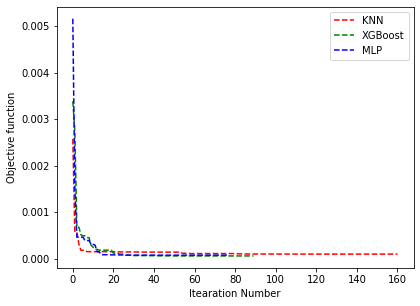

In [92]:
file_name=['./results/6 features as such 1 model/knn_obj.npy',
           './results/6 features as such 1 model/xgb_obj.npy',
           './results/6 features as such 1 model/mlp_obj.npy']
obj_vec=[]
for file in file_name:
    obj_vec.append(np.load(file))
    
import matplotlib.pyplot as plt
plt.figure(figsize=(6.4,4.8))
plt.plot(obj_vec[0],'r--',label='KNN')
plt.plot(obj_vec[1],'g--',label='XGBoost')
plt.plot(obj_vec[2],'b--',label='MLP')
plt.xlabel('Itearation Number')
plt.ylabel('Objective function')
#plt.title('loss curve')
plt.legend(loc='upper right')
plt.show()    

In [90]:
x0,x=[0.22,1.62,2.43,1.83,0.56,0.77,0.39,1.70],[0]*8

In [91]:
q=[0.99398116, 0.98014432, 0.99987871, 1.01938244]

In [92]:
for i in range(len(q)):
    x[2*i]=q[i]*x0[2*i]
    x[2*i+1]=q[i]*x0[2*i+1]

In [93]:
x

[0.21867585520000002,
 1.6102494792000002,
 2.3817506976000002,
 1.7936641056,
 0.5599320776000001,
 0.7699066067,
 0.3975591516,
 1.732950148]